#### **Importing the Libraries**

In [57]:
import numpy as np
import yfinance as yf
import pandas as pd
from math import asin, sqrt
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from math import floor
from fredapi import Fred
import seaborn as sns
import itertools
from qiskit_aer import AerSimulator
from qiskit.providers.basic_provider import BasicProvider
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Options
from qiskit_ibm_runtime import SamplerV2 
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from pgmpy.models import BayesianModel,BayesianNetwork
from pgmpy.base import DAG
from pgmpy.factors.discrete import TabularCPD
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator, BicScore, K2Score, HillClimbSearch
import networkx as nx
import pylab as plt
import pyfolio as pf
import heapq

# silence warnings
import warnings
warnings.filterwarnings('ignore')

#### **Starting Quantum Runtime Services**

In [58]:
## Qiskit Runtime service initialization
QiskitRuntimeService.save_account(channel = 'ibm_quantum',
                                  token = 'afbbd92eae66abcc98ea8bfd6269888a2fbeb2cc875b1f30c6cc67ced46d4b5ef84270be2de6c64361ec83180dd3f6f1c616db0debf34cdf5d7816ba9d374597',
                                  instance='ibm-q/open/main',
                                  overwrite=True)
service = QiskitRuntimeService(verify=False)



#### **Utility Functions**

In [59]:
######## utility functions ############
#### Utility functions for QBN ######

def prob_to_angle(prob):
    return 2*asin(sqrt(prob))


def bit_str_2_arr(bitstring):
	my_state = bitstring[::-1]
	bit_array = np.zeros(len(my_state))
	for i in range(len(my_state)):
		if int(my_state[i]) == 0:
			pass
		else:
			bit_array[i] = int(my_state[i])
	return bit_array



def custom_mcry(circuit,angle,control_qubits,target,control_state):
	# Multi-coltrolled Ry gate #
	Id = []
	for i in range(len(control_state)):
		c = control_state[i]
		if c == '0':
			Id.append(control_qubits[i])			
		else:
			pass
	if len(Id) == 0:
		pass
	else:
		circuit.x(Id)
	circuit.mcry(angle,control_qubits,target)
	if len(Id) == 0:
		pass
	else:
		circuit.x(Id)
	return circuit


def feature_map(x,method = 'default'):
    if method == 'on_axis':
        if x > np.pi/2:
            theta = np.pi 
        elif x <= np.pi/2:
            theta = 0    
        else:
            theta = x
    elif method == 'shift':
        if x > np.pi/2:
            theta = x + np.pi/4 + (x - np.pi/2)
        elif x < np.pi/2:
            theta = x - np.pi/4 - (np.pi/2 - x)
        else:
            theta = x
    elif method == 'default':
        theta = x
    return theta


def encode_data(data_row): # Encoding angle data to quantum circuit Ry gates
    qc= QuantumCircuit([]) #,cr)

    quantum_data = QuantumCircuit(data_row.shape[0],)
    for j in range(len(data_row)):
        quantum_data.ry(feature_map(data_row[j]),j)

    quantum_data.barrier()
    return quantum_data


def my_trade(state,price,prev_log):

# log = {'state':np.nan,'buy_price':np.nan,'sell_price':np.nan,'signal':0,
#       'position':0,'portfolio value':0, 'cash':initial_cash,'last purchase price': np.nan}

    prev_state = prev_log['state']
    trade_log = {'state':state,}

    if state > prev_state: 
        # print("Prev {}, current {} ---> BUY!".format(prev_state,state))
        trade_log['signal'] = +1

        if prev_log['cash'] > 0:
            trade_log['position'] = prev_log['cash']/price
            trade_log['cash'] = 0
            trade_log['buy_price'] = price
            trade_log['sell_price'] = np.nan
            trade_log['last purchase price'] = trade_log['buy_price']
        else:
            trade_log['position'] = prev_log['position']
            trade_log['cash'] = prev_log['cash']
            trade_log['buy_price'] = np.nan
            trade_log['sell_price'] = np.nan
            trade_log['last purchase price'] = 0

    elif state < prev_state: 
        # print("Prev {}, current {} ---> SELL!".format(prev_state,state))
        trade_log['signal'] = -1
        if prev_log['position'] > 0 and price > prev_log['last purchase price']: # include buy price and if purchase price < current price
            trade_log['cash'] = prev_log['position']*price
            trade_log['position'] = 0
            trade_log['buy_price'] = np.nan
            trade_log['sell_price'] = price
            trade_log['last purchase price'] = 0
        else:
            trade_log['position'] = prev_log['position']
            trade_log['cash'] = prev_log['cash']
            trade_log['buy_price'] = np.nan
            trade_log['sell_price'] = np.nan
            trade_log['last purchase price'] = prev_log['last purchase price']
    else:
        # print("Prev {}, current {} ---> HOLD!".format(prev_state,state))
        trade_log['signal'] = 0
        trade_log['buy_price'] = np.nan
        trade_log['sell_price'] = np.nan
        trade_log['position'] = prev_log['position']
        trade_log['cash'] = prev_log['cash']
        trade_log['last purchase price'] = prev_log['last purchase price']

    # print(">>-----",prev_log)
    # print("----->>",trade_log)
    trade_log['portfolio value'] = trade_log['cash'] + (trade_log['position']*price)
    return trade_log


# **Data Collection & Preprocessing**

[*********************100%%**********************]  7 of 7 completed


Ticker,BTC-USD,CNY=X,EUR=X,NVDA,^GSPC,^TNX,^VIX
Date,,,,,,,
2017-01-03,1043.839966,6.9440,0.95602,2.513282,2257.830078,2.450,12.85
2017-01-04,1154.729980,6.9598,0.95970,2.571920,2270.750000,2.452,11.85
2017-01-05,1013.380005,6.9251,0.95230,2.506631,2269.000000,2.368,11.67
2017-01-06,902.200989,6.8879,0.94287,2.540137,2276.979980,2.418,11.32
2017-01-09,902.828003,6.9175,0.94950,2.643123,2268.899902,2.376,11.56


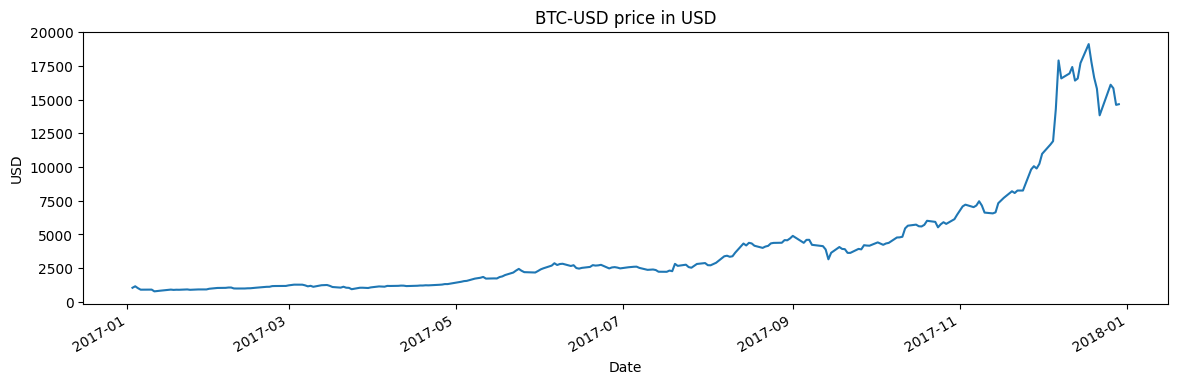

In [60]:
start_date = '2017-01-01'#'2019-01-01'
end_date = '2017-12-31'  #'2019-06-30'

# ^SOX > PHLX semiconductor data
# CNY=X > Yuan to USD forex rate
# EUR=X > EURO to USD forex rate
# ^TNX > CBOE Interest Rate 10 Year T No

target = "BTC-USD"
tickers = [target,"^VIX","NVDA","^GSPC","CNY=X","EUR=X","^TNX"] # "GC=F","^NDX"]

###### Stock Data Collection #######
###### The trading algoorithm will be designed for this Assets #############
data0 = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
data0.dropna(inplace=True)

# (data0/data0.iloc[0,:])[target].plot(figsize=(14,4))
data0[target].plot(figsize=(14,4))
plt.title(f"{target} price in USD")
plt.ylabel("USD")
data0.head()

In [61]:
# fred = Fred(api_key='8bd22ac3ad2b9cdcbe7c4d5bb66e94ae')

# # 'DCOILWTICO' > West Texas Intermediate (WTI) - Cushing, Oklahoma - crude oil
# # DFF' > Federal fund rate
# series_ids = ['DCOILWTICO'] # ,'DFF']

# data1 = pd.DataFrame()

# # Loop through each series ID and fetch the data
# for series_id in series_ids:
#     df = fred.get_series(series_id)
#     data1[series_id] = df

# # Filter the DataFrame to include data only from 2010 to 2020
# data1 = data1.loc[data0.index]
# data1.head()

In [62]:
##### Joining two dataframes #####
data = data0
# data = pd.concat([data0,data1],axis=1)
# data.head()

In [63]:
####### removing NaN vaalues from the data set ################
data = data.dropna()
print("Number of available samples are",data.shape[0])
print("Number of NaN value on each columns are:\n",data.isna().sum())
# data.head()

Number of available samples are 249
Number of NaN value on each columns are:
 Ticker
BTC-USD    0
CNY=X      0
EUR=X      0
NVDA       0
^GSPC      0
^TNX       0
^VIX       0
dtype: int64


#### **Data Preparation 1:** Converting to Percentage changes data

In [64]:
###### Converting to Percentage changes data ##########
data = data.pct_change().dropna()
data.head()

Ticker,BTC-USD,CNY=X,EUR=X,NVDA,^GSPC,^TNX,^VIX
Date,,,,,,,
2017-01-04,0.106233,0.002275,0.003849,0.023331,0.005722,0.000816,-0.077821
2017-01-05,-0.122410,-0.004986,-0.007711,-0.025385,-0.000771,-0.034258,-0.015190
2017-01-06,-0.109711,-0.005372,-0.009902,0.013367,0.003517,0.021115,-0.029991
2017-01-09,0.000695,0.004297,0.007032,0.040543,-0.003549,-0.017370,0.021201
2017-01-10,0.005373,0.002776,-0.005361,-0.007550,0.000000,0.001263,-0.006055


#### **Data Preparation 2:** Splitting into training & testing set

In [65]:
#### splitting the data into train and test set
split_ratio = 0.7
split_end = int(data.shape[0]*split_ratio)

train_data = data.iloc[:split_end,:]
test_data = data.iloc[split_end:,:]


print("Size of train data is of {}% is {} samples".format(split_ratio*100,train_data.shape[0]))
print("Size of test data is of {}% is {} samples".format(round(1-split_ratio)*100,test_data.shape[0]))

Size of train data is of 70.0% is 173 samples
Size of test data is of 0% is 75 samples


#### **Data Preparation 3:** Discretizing/Binarizing the Training Data

In [66]:
########### Discretizing/Binarizing percentage change data #############
 
dscrt_train_data = train_data.applymap(lambda x: 1 if x >0 else 0)
dscrt_train_data['forecast'] = dscrt_train_data[target].shift(-1)
dscrt_train_data.dropna(inplace=True)
dscrt_train_data['forecast'] = dscrt_train_data['forecast'].apply(np.int64)
dscrt_train_data.head()

Ticker,BTC-USD,CNY=X,EUR=X,NVDA,^GSPC,^TNX,^VIX,forecast
Date,,,,,,,,
2017-01-04,1,1,1,1,1,1,0,0
2017-01-05,0,0,0,0,0,0,0,0
2017-01-06,0,0,0,1,1,1,0,1
2017-01-09,1,1,1,1,0,0,1,1
2017-01-10,1,1,0,0,0,1,0,0


In [67]:
####### state distribution of each data columns

for col in dscrt_train_data.columns:
    print("States distribution in {} is {}".format(col,dscrt_train_data[col].value_counts().to_dict()))



States distribution in BTC-USD is {1: 110, 0: 62}
States distribution in CNY=X is {0: 89, 1: 83}
States distribution in EUR=X is {0: 87, 1: 85}
States distribution in NVDA is {1: 93, 0: 79}
States distribution in ^GSPC is {1: 94, 0: 78}
States distribution in ^TNX is {0: 90, 1: 82}
States distribution in ^VIX is {0: 93, 1: 79}
States distribution in forecast is {1: 109, 0: 63}


# **BNSL & QBN Construction**

  0%|          | 0/1000000 [00:00<?, ?it/s]

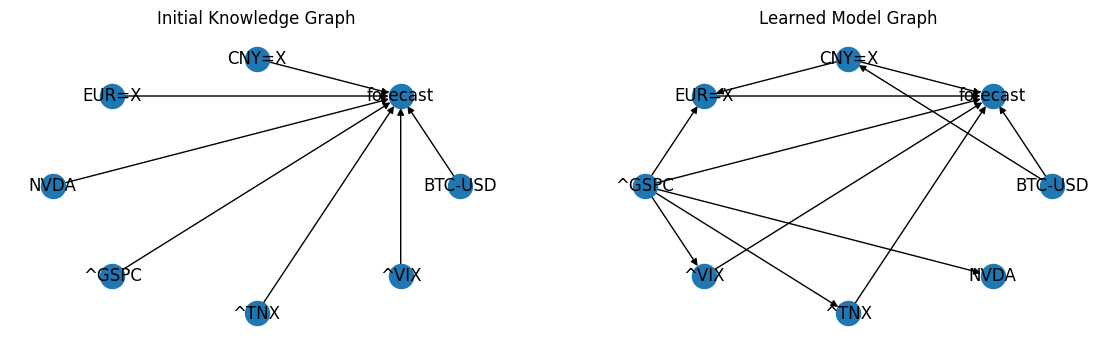

In [68]:
########## Constructing sample knowledge graph of Belief Network #####
 
my_edges = []
for col in dscrt_train_data.columns:
    if col == 'forecast':
        pass
    else:
        my_edges.append((col,'forecast'))
### Sample prior knowledge graph
# print("possible edges will be:",my_edges)

##### Contructing Prior Graph Image using NetworkX ####
G=nx.DiGraph()
G.add_edges_from(my_edges)
label_dict1 = {}
for node in G.nodes():
    label_dict1[node] = node
pos = nx.spring_layout(G)



############ Appliying hillclimb search to best Bayesian network ###########
################## If some prior structure is known ########################

edges = my_edges ## Feeding the prior knowledge graph
model = BayesianNetwork()
model.add_nodes_from(nodes=list(dscrt_train_data.columns))
model.add_edges_from(edges)
hc = HillClimbSearch(dscrt_train_data,state_names=dict(map(lambda e: (e, [0, 1]),dscrt_train_data),
                                                       node_names=list(dscrt_train_data.columns)))
k2 = K2Score(dscrt_train_data)
learned_model = hc.estimate(start_dag=model,scoring_method=k2)
# print("Learned bayesian structure edges are:\n",learned_model.edges())
##### Fitting the Data into Learned Model ###############
learned_model.fit(dscrt_train_data,state_names=dict(map(lambda e: (e, [0, 1]), dscrt_train_data.columns)),
                  estimator=BayesianEstimator, prior_type="K2")

######## Drawing the network ######################
H=nx.DiGraph()
H.add_edges_from(learned_model.edges())
H.add_nodes_from(learned_model.nodes())
label_dict2 = {}
for node in H.nodes():
    label_dict2[node] = node
pos = nx.spring_layout(H)

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.title("Initial Knowledge Graph")
nx.draw_circular(G,labels=label_dict1,)

plt.subplot(1,2,2)
plt.title("Learned Model Graph")
nx.draw_circular(H,labels=label_dict2,)
plt.show()

In [69]:
len(H.edges())

12

#### **Extraction of CPD Table**

In [70]:
### Optimal Belief Network Configurations #########

print('Nodes of the model:',learned_model.nodes())
print('Edges of the model:',learned_model.edges())

#### Printing CPD table of the dataset ###########
for model in learned_model.get_cpds():
    print("\n\nThe CPD table is:\n",model)


Nodes of the model: ['BTC-USD', 'CNY=X', 'EUR=X', 'NVDA', '^GSPC', '^TNX', '^VIX', 'forecast']
Edges of the model: [('BTC-USD', 'forecast'), ('BTC-USD', 'CNY=X'), ('CNY=X', 'forecast'), ('CNY=X', 'EUR=X'), ('EUR=X', 'forecast'), ('^GSPC', 'forecast'), ('^GSPC', '^VIX'), ('^GSPC', '^TNX'), ('^GSPC', 'EUR=X'), ('^GSPC', 'NVDA'), ('^TNX', 'forecast'), ('^VIX', 'forecast')]


The CPD table is:
 +------------+----------+
| BTC-USD(0) | 0.362069 |
+------------+----------+
| BTC-USD(1) | 0.637931 |
+------------+----------+


The CPD table is:
 +----------+------------+---------------------+
| BTC-USD  | BTC-USD(0) | BTC-USD(1)          |
+----------+------------+---------------------+
| CNY=X(0) | 0.625      | 0.45535714285714285 |
+----------+------------+---------------------+
| CNY=X(1) | 0.375      | 0.5446428571428571  |
+----------+------------+---------------------+


The CPD table is:
 +----------+----------+--------------------+--------------------+----------+
| CNY=X    | CNY=X(0)

#### **Traing of Quantum Belief Network:** From CPD Table

In [71]:
#### QuantumCircuit initialization ####
node_list = list(learned_model.nodes())
# cr = ClassicalRegister(1,'signal')
qc= QuantumCircuit([]) #,cr)

for node in node_list:
    qc.add_register(QuantumRegister(1,node)) # Adding qubits with names same as nodes


data_qc = qc.copy()
model_qc = qc.copy()
######### Contructing the QBN from available CPD and ###### 
######### the Learned Belief Network Structure       #######
for i in range(len(learned_model.get_cpds())):
    my_model = learned_model.get_cpds()[i]
    print('\n\nModel state space:',my_model.state_names)



    if len(my_model.variables) == 1:
        cpd = pd.DataFrame(my_model.get_values(),columns=['Probs']).rename_axis(my_model.variable,axis=1)
        cpd['theta'] = 2*np.arctan(np.sqrt(cpd['Probs'].iloc[0]/cpd['Probs'].iloc[1]))
        print(cpd)

        data_qc.ry(prob_to_angle(my_model.values[1]),node_list.index(my_model.variable))
    else:
        print('Control:',my_model.variables[1:],'-----------> Target:',my_model.variable)

        lst = np.array(list(itertools.product([0, 1], repeat=len(my_model.variables)-1)))
        cpd = pd.DataFrame(np.array(lst),columns = my_model.variables[1:])
        cpd['Prob_'+ my_model.variable + str(0)] = my_model.get_values()[0,:]
        cpd['Prob_'+ my_model.variable + str(1)] = my_model.get_values()[1,:]
        cpd['theta'] = 2*np.arctan(np.sqrt(cpd['Prob_'+ my_model.variable + str(0)]/cpd['Prob_'+ my_model.variable + str(1)]))
        print(cpd)

        for j in range(cpd.shape[0]):
            ctrls = [str(int(z)) for z in cpd.iloc[j,:-3].values]
            ctrls = ''.join(ctrls)
            # print("The control state is",ctrls)
            model_qc = custom_mcry(model_qc,cpd.iloc[j,-1],[node_list.index(j) for j in my_model.variables[1:]],node_list.index(my_model.variable),ctrls)

    model_qc.barrier()

# qc.measure_all()
# qc.draw('mpl',fold=60)



Model state space: {'BTC-USD': [0, 1]}
BTC-USD     Probs    theta
0        0.362069  1.29131
1        0.637931  1.29131


Model state space: {'CNY=X': [0, 1], 'BTC-USD': [0, 1]}
Control: ['BTC-USD'] -----------> Target: CNY=X
   BTC-USD  Prob_CNY=X0  Prob_CNY=X1     theta
0        0     0.625000     0.375000  1.823477
1        1     0.455357     0.544643  1.481392


Model state space: {'EUR=X': [0, 1], 'CNY=X': [0, 1], '^GSPC': [0, 1]}
Control: ['CNY=X', '^GSPC'] -----------> Target: EUR=X
   CNY=X  ^GSPC  Prob_EUR=X0  Prob_EUR=X1     theta
0      0      0     0.625000     0.375000  1.823477
1      0      1     0.716981     0.283019  2.019682
2      1      0     0.452381     0.547619  1.475414
3      1      1     0.200000     0.800000  0.927295


Model state space: {'NVDA': [0, 1], '^GSPC': [0, 1]}
Control: ['^GSPC'] -----------> Target: NVDA
   ^GSPC  Prob_NVDA0  Prob_NVDA1     theta
0      0    0.537500    0.462500  1.645867
1      1    0.395833    0.604167  1.360926


Model state 

#### **Quantum Circuit of Quantum Belief Network**

Depth of the circuit is: 602
Gate operations is:
 OrderedDict([('x', 400), ('mcx_vchain', 256), ('unitary', 256), ('ry', 24), ('cx', 16), ('barrier', 8), ('ccx', 8)])


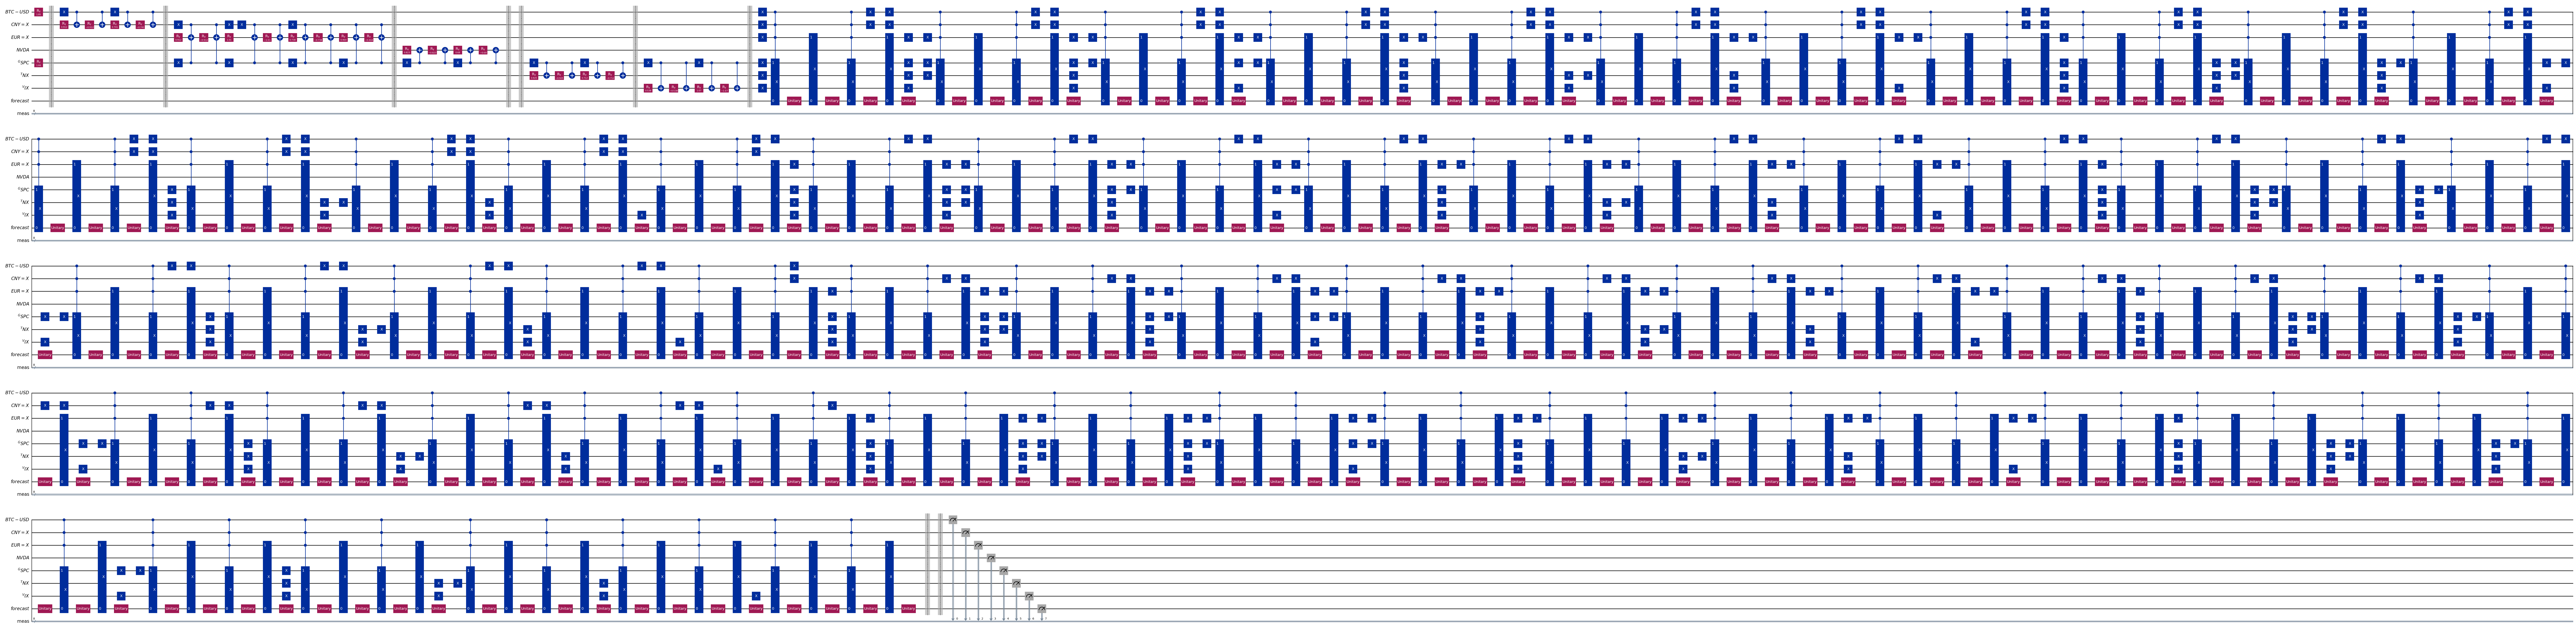

In [72]:
#### Combine the circuit ##############33
qbn_qc = data_qc.compose(model_qc,qubits = range(model_qc.num_qubits))
print("Depth of the circuit is:",model_qc.depth())
print("Gate operations is:\n",model_qc.count_ops())
qbn_qc.measure_all()
qbn_qc.draw('mpl',fold=200)

In [73]:
# qbn_qc.draw('mpl',fold=70)

#### **QBN Execution on IBM Quantum Simulator:** Exploring the Probable Events 

In [74]:
##### Running on simulator #####
backend = AerSimulator()
# warnings.filterwarnings('ignore')
# pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
# isa_circuit = pm.run(qbn_qc)

# print("Original Circuit depth is",qbn_qc.depth())
# print("Transpiled Cicuit depth is",isa_circuit.depth())


with Session(service, backend = backend) as session:
    sampler = Sampler(session=session)

    job = sampler.run(qbn_qc, shots=1000)
    result = job.result()
    binary_data = result.quasi_dists[0].binary_probabilities()
    state = max(zip(binary_data.values(), binary_data.keys()))[1]
    print(f"\n\n State with max probability is: {state}")


base_primitive._run_primitive:INFO:2024-07-29 19:28:29,718: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01740 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 4.21262 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02050 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 559.19623 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_am



 State with max probability is: 11010011




 State with max probability is: 11010011


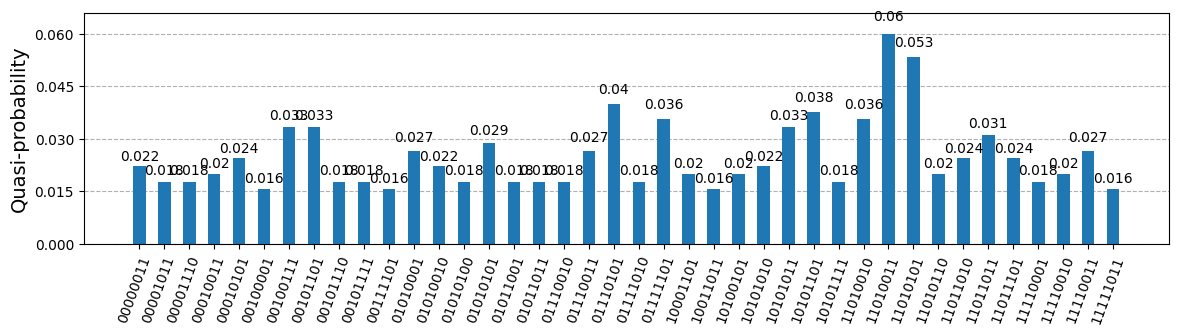

In [75]:
######## Plotting the distribution #############
print(f"\n\n State with max probability is: {state}")

m = 40 # take m largest probability values
top_keys = heapq.nlargest(m, binary_data, key=binary_data.get)
top_states = {key: binary_data[key] for key in top_keys}
plot_histogram(top_states,figsize=(14,3))

# **Forecasting with Trained QBN on Training Data**

In [76]:
train_data.head()

Ticker,BTC-USD,CNY=X,EUR=X,NVDA,^GSPC,^TNX,^VIX
Date,,,,,,,
2017-01-04,0.106233,0.002275,0.003849,0.023331,0.005722,0.000816,-0.077821
2017-01-05,-0.122410,-0.004986,-0.007711,-0.025385,-0.000771,-0.034258,-0.015190
2017-01-06,-0.109711,-0.005372,-0.009902,0.013367,0.003517,0.021115,-0.029991
2017-01-09,0.000695,0.004297,0.007032,0.040543,-0.003549,-0.017370,0.021201
2017-01-10,0.005373,0.002776,-0.005361,-0.007550,0.000000,0.001263,-0.006055


#### **Scaling the Training Data:** Adjusting the Reference Level of Percentage Change Data

In [77]:
############ Shifting the mean/referenc e level of the data 
transformed_train_data = train_data.apply(lambda x: (x + (0.5-data.mean())),axis=1)
transformed_train_data.head()

Ticker,BTC-USD,CNY=X,EUR=X,NVDA,^GSPC,^TNX,^VIX
Date,,,,,,,
2017-01-04,0.593890,0.502518,0.504372,0.520412,0.505032,0.500781,0.420355
2017-01-05,0.365248,0.495257,0.492812,0.471695,0.498539,0.465707,0.482986
2017-01-06,0.377946,0.494871,0.490621,0.510447,0.502826,0.521080,0.468184
2017-01-09,0.488352,0.504540,0.507555,0.537624,0.495761,0.482595,0.519377
2017-01-10,0.493031,0.503018,0.495162,0.489530,0.499310,0.501227,0.492120


#### **Converting Training Data to Quantum Data:** Scaling the Percentage Change Data between 0 to $\pi$ for $R_{y}(\theta)$ Gate

In [78]:
####### The Quantum Data: Angle data over bloch sphere ##############
train_quantum_data = 2*np.arctan(np.sqrt((transformed_train_data)/(1-transformed_train_data)))
train_quantum_data['actual'] = dscrt_train_data['forecast']
train_quantum_data.dropna(inplace=True)
train_quantum_data['actual'] = train_quantum_data['actual'].apply(np.int64)
train_quantum_data.head()

Ticker,BTC-USD,CNY=X,EUR=X,NVDA,^GSPC,^TNX,^VIX,actual
Date,,,,,,,,
2017-01-04,1.759698,1.575832,1.579541,1.611631,1.580860,1.572358,1.410824,0
2017-01-05,1.297918,1.561309,1.556421,1.514156,1.567874,1.502157,1.536761,0
2017-01-06,1.324197,1.560537,1.552037,1.591692,1.576449,1.612968,1.507121,1
2017-01-09,1.547499,1.579876,1.585907,1.646115,1.562318,1.535979,1.609560,1
2017-01-10,1.556857,1.576832,1.561121,1.549855,1.569415,1.573251,1.555036,0


In [79]:
# train_quantum_data.describe()

#### **Bloch Sphere Representation:** of one Quantum Data Sample

Binarized classical data: {'BTC-USD': 1, 'CNY=X': 1, 'EUR=X': 1, 'NVDA': 1, '^GSPC': 1, '^TNX': 1, '^VIX': 0}


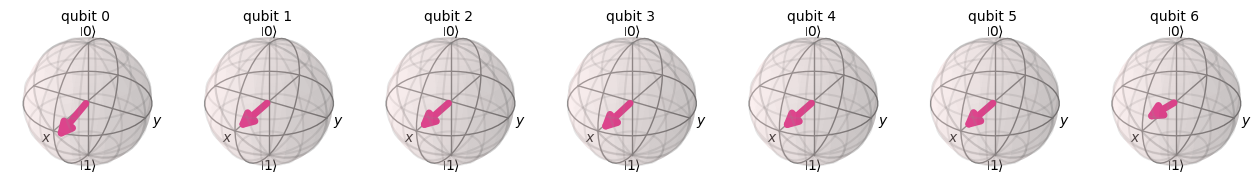

In [80]:
################ Plotting one sample quantum train data row 
################ Individual bloch sphere corresponding to each variables ##########

bloch_sp_data= QuantumCircuit([])
for i in range(train_quantum_data.shape[1]-1):
    bloch_sp_data.add_register(QuantumRegister(1,train_quantum_data.columns[i]))
    bloch_sp_data.ry(feature_map(train_quantum_data.iloc[0,i],method='default'),i)

print("Binarized classical data:",dict(dscrt_train_data.iloc[0,:-1]))
plot_bloch_multivector(Statevector(bloch_sp_data))


#### **Correlation in Quantum Data**

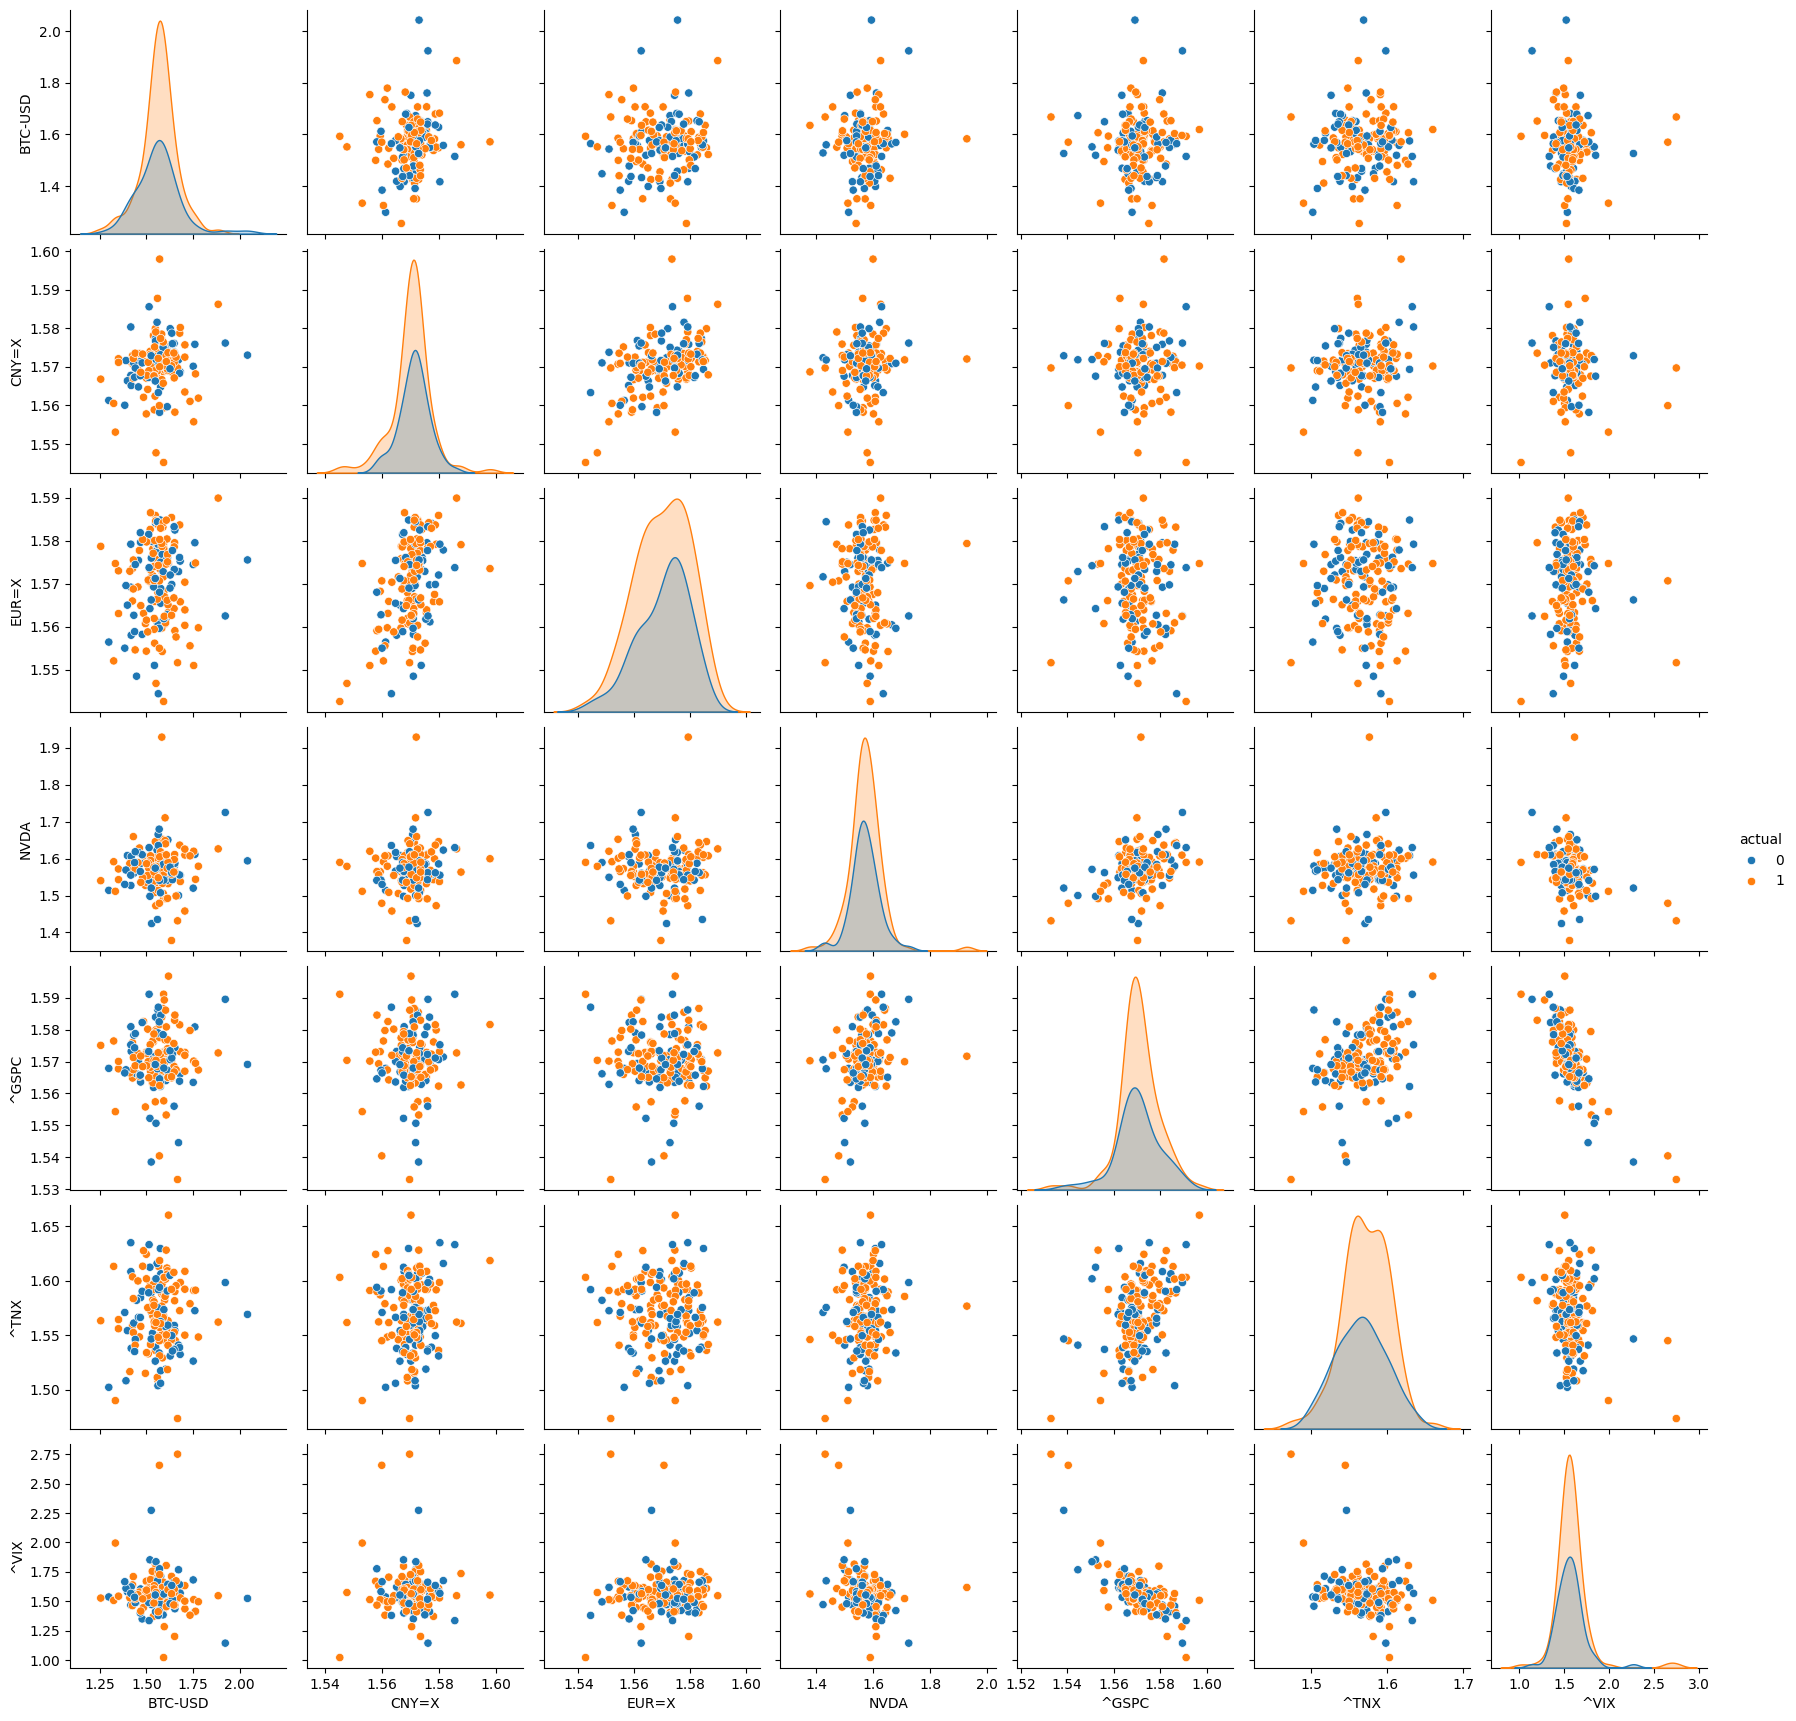

In [81]:
sns.pairplot(train_quantum_data.applymap(feature_map),hue='actual');

#### **QBN Strategy on Quantum Training Data Set:** Forecasting Price Movements & Implementation of QBN Trading Strategy using Qiskit Aer Quantum Simulator

In [82]:
initial_cash = 100000
scenario = {1:'BUY !!!',0:'HOLD !!!',-1:'SELL !!!'}


SIGNALS = []
STATES = []
BUY_PRICE = []
SELL_PRICE = []
POSITIONS = []
PORT_VALUE = []
CASH = []

log = {'state':np.nan,'buy_price':np.nan,'sell_price':np.nan,'signal':0,
       'position':0,'portfolio value':initial_cash,'cash':initial_cash,
       'last purchase price': 0}

# cr = ClassicalRegister(1)
# model_qc.add_register(cr)

z = 0

for i in range(z,train_quantum_data.shape[0]):
    price = data0.loc[train_quantum_data.index[i]][0]
    row = np.append(train_quantum_data.iloc[i,:data.shape[1]].values,0)   
    my_data = encode_data(row) 
    # my_data.append(model_qc,qargs=range(train_quantum_data.iloc[i,:].values.shape[0]),cargs=[0])
    # my_data.append(model_qc,qargs=np.arange(data.shape[1]+1),cargs=[0])
    qbn_circuit = my_data.compose(model_qc,qubits = range(my_data.num_qubits))#,clbits=[0,])
    cr = ClassicalRegister(1)

    qbn_circuit.add_register(cr)
    qbn_circuit.measure(-1,0)

    with Session(service, backend = AerSimulator()) as session:
        sampler = Sampler(session=session)
        result = sampler.run(qbn_circuit,shots=100).result()
        binary_data = result.quasi_dists[0].binary_probabilities()
        state = int(max(zip(binary_data.values(), binary_data.keys()))[1])

    if i == 0:
        log['state'] = state
        if state == 1:
            signal = 1
        else:
            signal = log['signal']

        state = log['state']
        buy_price, sell_price = log['buy_price'],log['sell_price']
        position, port_value, cash = log['position'],log['portfolio value'],log['cash']             
        new_log = log

    elif i == train_quantum_data.shape[0]-1:
        new_log = my_trade(state,price,log)
        state, signal = new_log['state'],new_log['signal']
        buy_price, sell_price = new_log['buy_price'],new_log['sell_price']
        if new_log['position'] > 0:
            cash = new_log['position']*price
            position = 0
            port_value = cash
        else:
            position, port_value, cash = new_log['position'],new_log['portfolio value'],new_log['cash'] 


    else:
        new_log = my_trade(state,price,log)
        state, signal = new_log['state'],new_log['signal']
        buy_price, sell_price = new_log['buy_price'],new_log['sell_price']
        position, port_value, cash = new_log['position'],new_log['portfolio value'],new_log['cash'] 


    log = new_log
    SIGNALS.append(signal)
    BUY_PRICE.append(buy_price)
    SELL_PRICE.append(sell_price)
    STATES.append(state)
    POSITIONS.append(position)
    PORT_VALUE.append(port_value)
    CASH.append(cash)



    print("\n\n{}: The signal for the next day is {} with expected price movement of {}"
          .format(train_quantum_data.index[i].date(),scenario[signal],state))
    print(log)


base_primitive._run_primitive:INFO:2024-07-29 19:29:02,999: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01597 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 3.85928 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01836 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 385.07009 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amp



2017-01-04: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'buy_price': nan, 'sell_price': nan, 'signal': 0, 'position': 0, 'portfolio value': 100000, 'cash': 100000, 'last purchase price': 0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 356.11224 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-01-05: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 360.98623 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-01-06: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 353.57308 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-01-09: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 344.13886 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-01-10: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 411.45205 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-01-11: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 361.60684 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('u1', 1), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-01-12: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 339.04290 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-01-13: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 344.43402 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-01-17: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 389.59694 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-01-18: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 586.73573 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-01-19: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 1432.80721 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'm



2017-01-20: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 438.12418 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-01-23: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02217 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 7.41935 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02050 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 498.67463 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'dela



2017-01-24: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 364.16245 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-01-25: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 339.51139 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('u1', 1), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-01-26: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 483.91986 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-01-27: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 433.53939 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-01-30: The signal for the next day is BUY !!! with expected price movement of 1
{'state': 1, 'signal': 1, 'position': 108.65053633270884, 'cash': 0, 'buy_price': 920.3820190429688, 'sell_price': nan, 'last purchase price': 920.3820190429688, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01621 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 5.86987 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01431 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 327.98028 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'dela



2017-01-31: The signal for the next day is SELL !!! with expected price movement of 0
{'state': 0, 'signal': -1, 'cash': 105434.80805348227, 'position': 0, 'buy_price': nan, 'sell_price': 970.4030151367188, 'last purchase price': 0, 'portfolio value': 105434.80805348227}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 442.64793 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-02-01: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 105434.80805348227, 'last purchase price': 0, 'portfolio value': 105434.80805348227}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 790.78722 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('u1', 1), ('ccx', 3), ('rccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-02-02: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 105434.80805348227, 'last purchase price': 0, 'portfolio value': 105434.80805348227}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 518.22090 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('u1', 1), ('ccx', 3), ('rccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-02-03: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 105434.80805348227, 'last purchase price': 0, 'portfolio value': 105434.80805348227}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 648.52357 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-02-06: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 105434.80805348227, 'last purchase price': 0, 'portfolio value': 105434.80805348227}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 346.39716 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('u1', 1), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-02-07: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 105434.80805348227, 'last purchase price': 0, 'portfolio value': 105434.80805348227}


INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 37.29320 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02313 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 1591.31122 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'sav



2017-02-08: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 105434.80805348227, 'last purchase price': 0, 'portfolio value': 105434.80805348227}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 736.65047 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-02-09: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 105434.80805348227, 'last purchase price': 0, 'portfolio value': 105434.80805348227}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02098 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 6.33502 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02289 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 1273.10991 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'del



2017-02-10: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 105434.80805348227, 'last purchase price': 0, 'portfolio value': 105434.80805348227}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 452.23665 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('u1', 1), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-02-13: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 105434.80805348227, 'last purchase price': 0, 'portfolio value': 105434.80805348227}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 455.78218 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('u1', 1), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-02-14: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 105434.80805348227, 'last purchase price': 0, 'portfolio value': 105434.80805348227}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 352.94962 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-02-15: The signal for the next day is BUY !!! with expected price movement of 1
{'state': 1, 'signal': 1, 'position': 104.65201303992824, 'cash': 0, 'buy_price': 1007.47998046875, 'sell_price': nan, 'last purchase price': 1007.47998046875, 'portfolio value': 105434.80805348227}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 367.51461 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-02-16: The signal for the next day is SELL !!! with expected price movement of 0
{'state': 0, 'signal': -1, 'cash': 107523.65814578997, 'position': 0, 'buy_price': nan, 'sell_price': 1027.43994140625, 'last purchase price': 0, 'portfolio value': 107523.65814578997}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 912.28294 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-02-17: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 107523.65814578997, 'last purchase price': 0, 'portfolio value': 107523.65814578997}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 382.60245 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('u1', 1), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-02-21: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 107523.65814578997, 'last purchase price': 0, 'portfolio value': 107523.65814578997}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 342.93580 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-02-22: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 107523.65814578997, 'last purchase price': 0, 'portfolio value': 107523.65814578997}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 362.97727 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-02-23: The signal for the next day is BUY !!! with expected price movement of 1
{'state': 1, 'signal': 1, 'position': 92.15892488836951, 'cash': 0, 'buy_price': 1166.719970703125, 'sell_price': nan, 'last purchase price': 1166.719970703125, 'portfolio value': 107523.65814578997}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 343.15705 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-02-24: The signal for the next day is SELL !!! with expected price movement of 0
{'state': 0, 'signal': -1, 'cash': 108165.09191292379, 'position': 0, 'buy_price': nan, 'sell_price': 1173.6800537109375, 'last purchase price': 0, 'portfolio value': 108165.09191292379}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 365.96894 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('u1', 1), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-02-27: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 108165.09191292379, 'last purchase price': 0, 'portfolio value': 108165.09191292379}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 333.40764 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-02-28: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 108165.09191292379, 'last purchase price': 0, 'portfolio value': 108165.09191292379}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02575 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 6.91700 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01168 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 439.38494 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'dela



2017-03-01: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 108165.09191292379, 'last purchase price': 0, 'portfolio value': 108165.09191292379}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 368.72339 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-03-02: The signal for the next day is BUY !!! with expected price movement of 1
{'state': 1, 'signal': 1, 'position': 86.46221138805146, 'cash': 0, 'buy_price': 1251.010009765625, 'sell_price': nan, 'last purchase price': 1251.010009765625, 'portfolio value': 108165.09191292379}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 592.60392 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('u1', 1), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-03-03: The signal for the next day is SELL !!! with expected price movement of 0
{'state': 0, 'signal': -1, 'cash': 110238.45405329419, 'position': 0, 'buy_price': nan, 'sell_price': 1274.989990234375, 'last purchase price': 0, 'portfolio value': 110238.45405329419}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02146 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 20.92433 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 653.30744 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'del



2017-03-06: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 110238.45405329419, 'last purchase price': 0, 'portfolio value': 110238.45405329419}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 807.06429 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-03-07: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 110238.45405329419, 'last purchase price': 0, 'portfolio value': 110238.45405329419}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 582.30257 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-03-08: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 110238.45405329419, 'last purchase price': 0, 'portfolio value': 110238.45405329419}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 1227.89717 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'm



2017-03-09: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 110238.45405329419, 'last purchase price': 0, 'portfolio value': 110238.45405329419}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 518.64910 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-03-10: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 110238.45405329419, 'last purchase price': 0, 'portfolio value': 110238.45405329419}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 758.75735 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-03-13: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 110238.45405329419, 'last purchase price': 0, 'portfolio value': 110238.45405329419}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 576.62106 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-03-14: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 110238.45405329419, 'last purchase price': 0, 'portfolio value': 110238.45405329419}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 580.54352 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-03-15: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 110238.45405329419, 'last purchase price': 0, 'portfolio value': 110238.45405329419}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 391.98375 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-03-16: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 110238.45405329419, 'last purchase price': 0, 'portfolio value': 110238.45405329419}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 575.13118 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-03-17: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 110238.45405329419, 'last purchase price': 0, 'portfolio value': 110238.45405329419}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 993.41488 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-03-20: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 110238.45405329419, 'last purchase price': 0, 'portfolio value': 110238.45405329419}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 405.00522 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('u1', 1), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-03-21: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 110238.45405329419, 'last purchase price': 0, 'portfolio value': 110238.45405329419}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 337.21590 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('u1', 1), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-03-22: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 110238.45405329419, 'last purchase price': 0, 'portfolio value': 110238.45405329419}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 377.92444 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('u1', 1), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-03-23: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 110238.45405329419, 'last purchase price': 0, 'portfolio value': 110238.45405329419}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 351.43733 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-03-24: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 110238.45405329419, 'last purchase price': 0, 'portfolio value': 110238.45405329419}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 452.77286 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-03-27: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 110238.45405329419, 'last purchase price': 0, 'portfolio value': 110238.45405329419}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 323.82917 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-03-28: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 110238.45405329419, 'last purchase price': 0, 'portfolio value': 110238.45405329419}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01431 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 4.28414 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01550 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 292.69648 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'dela



2017-03-29: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 110238.45405329419, 'last purchase price': 0, 'portfolio value': 110238.45405329419}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 290.65561 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('u1', 1), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-03-30: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 110238.45405329419, 'last purchase price': 0, 'portfolio value': 110238.45405329419}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 385.92529 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-03-31: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 110238.45405329419, 'last purchase price': 0, 'portfolio value': 110238.45405329419}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 412.46223 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-04-03: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 110238.45405329419, 'last purchase price': 0, 'portfolio value': 110238.45405329419}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 338.34028 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-04-04: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 110238.45405329419, 'last purchase price': 0, 'portfolio value': 110238.45405329419}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 419.32583 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-04-05: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 110238.45405329419, 'last purchase price': 0, 'portfolio value': 110238.45405329419}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 404.71697 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-04-06: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 110238.45405329419, 'last purchase price': 0, 'portfolio value': 110238.45405329419}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 388.29422 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-04-07: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 110238.45405329419, 'last purchase price': 0, 'portfolio value': 110238.45405329419}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 305.90487 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('u1', 1), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-04-10: The signal for the next day is BUY !!! with expected price movement of 1
{'state': 1, 'signal': 1, 'position': 92.86131560980668, 'cash': 0, 'buy_price': 1187.1300048828125, 'sell_price': nan, 'last purchase price': 1187.1300048828125, 'portfolio value': 110238.4540532942}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 359.89332 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-04-11: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 92.86131560980668, 'cash': 0, 'last purchase price': 1187.1300048828125, 'portfolio value': 111898.81482982193}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 318.52627 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-04-12: The signal for the next day is SELL !!! with expected price movement of 0
{'state': 0, 'signal': -1, 'cash': 111467.93696511925, 'position': 0, 'buy_price': nan, 'sell_price': 1200.3699951171875, 'last purchase price': 0, 'portfolio value': 111467.93696511925}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 313.31253 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-04-13: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 111467.93696511925, 'last purchase price': 0, 'portfolio value': 111467.93696511925}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 295.71128 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('u1', 1), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-04-17: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 111467.93696511925, 'last purchase price': 0, 'portfolio value': 111467.93696511925}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 775.92993 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-04-18: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 111467.93696511925, 'last purchase price': 0, 'portfolio value': 111467.93696511925}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 293.31613 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-04-19: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 111467.93696511925, 'last purchase price': 0, 'portfolio value': 111467.93696511925}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 314.45003 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-04-20: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 111467.93696511925, 'last purchase price': 0, 'portfolio value': 111467.93696511925}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 292.50860 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-04-21: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 111467.93696511925, 'last purchase price': 0, 'portfolio value': 111467.93696511925}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 292.03320 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-04-24: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 111467.93696511925, 'last purchase price': 0, 'portfolio value': 111467.93696511925}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 290.43651 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-04-25: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 111467.93696511925, 'last purchase price': 0, 'portfolio value': 111467.93696511925}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 293.51687 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-04-26: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 111467.93696511925, 'last purchase price': 0, 'portfolio value': 111467.93696511925}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 794.34633 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-04-27: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 111467.93696511925, 'last purchase price': 0, 'portfolio value': 111467.93696511925}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 403.79095 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-04-28: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 111467.93696511925, 'last purchase price': 0, 'portfolio value': 111467.93696511925}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 308.96878 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-05-01: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 111467.93696511925, 'last purchase price': 0, 'portfolio value': 111467.93696511925}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 307.44958 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-05-02: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 111467.93696511925, 'last purchase price': 0, 'portfolio value': 111467.93696511925}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 291.68248 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('u1', 1), ('ccx', 3), ('rccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-05-03: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 111467.93696511925, 'last purchase price': 0, 'portfolio value': 111467.93696511925}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 308.29096 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-05-04: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 111467.93696511925, 'last purchase price': 0, 'portfolio value': 111467.93696511925}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 291.87560 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-05-05: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 111467.93696511925, 'last purchase price': 0, 'portfolio value': 111467.93696511925}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 798.42710 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('u1', 1), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-05-08: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 111467.93696511925, 'last purchase price': 0, 'portfolio value': 111467.93696511925}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 289.74867 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-05-09: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 111467.93696511925, 'last purchase price': 0, 'portfolio value': 111467.93696511925}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 294.93046 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-05-10: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 111467.93696511925, 'last purchase price': 0, 'portfolio value': 111467.93696511925}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 290.07077 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('u1', 1), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-05-11: The signal for the next day is BUY !!! with expected price movement of 1
{'state': 1, 'signal': 1, 'position': 60.299550573613466, 'cash': 0, 'buy_price': 1848.5699462890625, 'sell_price': nan, 'last purchase price': 1848.5699462890625, 'portfolio value': 111467.93696511925}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 419.77859 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-05-12: The signal for the next day is SELL !!! with expected price movement of 0
{'state': 0, 'signal': -1, 'position': 60.299550573613466, 'cash': 0, 'buy_price': nan, 'sell_price': nan, 'last purchase price': 1848.5699462890625, 'portfolio value': 103970.89649218449}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 331.94470 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-05-15: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 60.299550573613466, 'cash': 0, 'last purchase price': 1848.5699462890625, 'portfolio value': 104826.55094243225}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 307.26671 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-05-16: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 60.299550573613466, 'cash': 0, 'last purchase price': 1848.5699462890625, 'portfolio value': 104586.55254808988}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01454 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 2.84266 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01764 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 382.80559 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'dela



2017-05-17: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 60.299550573613466, 'cash': 0, 'last purchase price': 1848.5699462890625, 'portfolio value': 110896.298403407}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 299.18194 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-05-18: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 60.299550573613466, 'cash': 0, 'last purchase price': 1848.5699462890625, 'portfolio value': 113884.74766301207}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 290.85755 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-05-19: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 60.299550573613466, 'cash': 0, 'last purchase price': 1848.5699462890625, 'portfolio value': 119858.01731522602}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 303.73192 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('u1', 1), ('ccx', 3), ('rccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-05-22: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 60.299550573613466, 'cash': 0, 'last purchase price': 1848.5699462890625, 'portfolio value': 131055.03732806352}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 309.76462 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('u1', 1), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-05-23: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 60.299550573613466, 'cash': 0, 'last purchase price': 1848.5699462890625, 'portfolio value': 139920.27843112178}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 318.64500 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-05-24: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 60.299550573613466, 'cash': 0, 'last purchase price': 1848.5699462890625, 'portfolio value': 147350.387286214}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 815.10997 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-05-25: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 60.299550573613466, 'cash': 0, 'last purchase price': 1848.5699462890625, 'portfolio value': 138989.25690344197}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 291.37182 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-05-26: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 60.299550573613466, 'cash': 0, 'last purchase price': 1848.5699462890625, 'portfolio value': 132804.93146343538}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 289.58035 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-05-30: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 60.299550573613466, 'cash': 0, 'last purchase price': 1848.5699462890625, 'portfolio value': 131179.8615197905}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 413.07855 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-05-31: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 60.299550573613466, 'cash': 0, 'last purchase price': 1848.5699462890625, 'portfolio value': 137869.49012725038}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 294.06810 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('u1', 1), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-06-01: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 60.299550573613466, 'cash': 0, 'last purchase price': 1848.5699462890625, 'portfolio value': 145194.07476883882}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 297.25075 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-06-02: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 60.299550573613466, 'cash': 0, 'last purchase price': 1848.5699462890625, 'portfolio value': 150058.44952427977}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 403.66316 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-06-05: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 60.299550573613466, 'cash': 0, 'last purchase price': 1848.5699462890625, 'portfolio value': 162013.4390098672}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 786.33451 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-06-06: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 60.299550573613466, 'cash': 0, 'last purchase price': 1848.5699462890625, 'portfolio value': 172649.67025805608}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 292.58633 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('u1', 1), ('ccx', 3), ('rccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-06-07: The signal for the next day is BUY !!! with expected price movement of 1
{'state': 1, 'signal': 1, 'position': 60.299550573613466, 'cash': 0, 'buy_price': nan, 'sell_price': nan, 'last purchase price': 0, 'portfolio value': 164748.0147954386}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 313.12895 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('u1', 1), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-06-08: The signal for the next day is SELL !!! with expected price movement of 0
{'state': 0, 'signal': -1, 'cash': 169177.632146695, 'position': 0, 'buy_price': nan, 'sell_price': 2805.6201171875, 'last purchase price': 0, 'portfolio value': 169177.632146695}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 291.83078 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-06-09: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 169177.632146695, 'last purchase price': 0, 'portfolio value': 169177.632146695}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 302.98972 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-06-12: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 169177.632146695, 'last purchase price': 0, 'portfolio value': 169177.632146695}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 291.44716 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-06-13: The signal for the next day is BUY !!! with expected price movement of 1
{'state': 1, 'signal': 1, 'position': 62.265876191770616, 'cash': 0, 'buy_price': 2717.02001953125, 'sell_price': nan, 'last purchase price': 2717.02001953125, 'portfolio value': 169177.632146695}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 300.78983 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-06-14: The signal for the next day is SELL !!! with expected price movement of 0
{'state': 0, 'signal': -1, 'position': 62.265876191770616, 'cash': 0, 'buy_price': nan, 'sell_price': nan, 'last purchase price': 2717.02001953125, 'portfolio value': 156061.3314075505}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01502 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 3.87979 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.00930 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 289.70695 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('u1', 1), ('ccx', 3), ('rccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'dela



2017-06-15: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 62.265876191770616, 'cash': 0, 'last purchase price': 2717.02001953125, 'portfolio value': 153459.2380092356}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 393.81576 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-06-16: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 62.265876191770616, 'cash': 0, 'last purchase price': 2717.02001953125, 'portfolio value': 156820.34878993698}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 299.68524 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-06-19: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 62.265876191770616, 'cash': 0, 'last purchase price': 2717.02001953125, 'portfolio value': 161243.71906686117}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 292.94562 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-06-20: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 62.265876191770616, 'cash': 0, 'last purchase price': 2717.02001953125, 'portfolio value': 169474.64159226013}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 296.77629 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-06-21: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 62.265876191770616, 'cash': 0, 'last purchase price': 2717.02001953125, 'portfolio value': 167439.17374794235}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 293.92123 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-06-22: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 62.265876191770616, 'cash': 0, 'last purchase price': 2717.02001953125, 'portfolio value': 168454.71863539136}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 778.41377 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-06-23: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 62.265876191770616, 'cash': 0, 'last purchase price': 2717.02001953125, 'portfolio value': 170914.2207449663}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 296.20099 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('u1', 1), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-06-26: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 62.265876191770616, 'cash': 0, 'last purchase price': 2717.02001953125, 'portfolio value': 154322.8578071679}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 292.70029 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('u1', 1), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-06-27: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 62.265876191770616, 'cash': 0, 'last purchase price': 2717.02001953125, 'portfolio value': 158930.53264535894}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 293.85138 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-06-28: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 62.265876191770616, 'cash': 0, 'last purchase price': 2717.02001953125, 'portfolio value': 160321.55779206986}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 295.51029 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-06-29: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 62.265876191770616, 'cash': 0, 'last purchase price': 2717.02001953125, 'portfolio value': 158112.98898774333}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 320.64676 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-06-30: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 62.265876191770616, 'cash': 0, 'last purchase price': 2717.02001953125, 'portfolio value': 154471.681764179}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 354.86364 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-07-03: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 62.265876191770616, 'cash': 0, 'last purchase price': 2717.02001953125, 'portfolio value': 159653.44615666254}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 980.20291 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-07-05: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 62.265876191770616, 'cash': 0, 'last purchase price': 2717.02001953125, 'portfolio value': 162015.18658416002}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 366.25648 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-07-06: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 62.265876191770616, 'cash': 0, 'last purchase price': 2717.02001953125, 'portfolio value': 162424.27764719634}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 362.49208 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-07-07: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 62.265876191770616, 'cash': 0, 'last purchase price': 2717.02001953125, 'portfolio value': 156826.5662565782}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 366.34874 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-07-10: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 62.265876191770616, 'cash': 0, 'last purchase price': 2717.02001953125, 'portfolio value': 147729.53086593846}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 301.74685 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-07-12: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 62.265876191770616, 'cash': 0, 'last purchase price': 2717.02001953125, 'portfolio value': 149365.8799164538}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 404.61898 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-07-13: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 62.265876191770616, 'cash': 0, 'last purchase price': 2717.02001953125, 'portfolio value': 146816.70339192398}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 306.25367 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-07-14: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 62.265876191770616, 'cash': 0, 'last purchase price': 2717.02001953125, 'portfolio value': 139060.87740671576}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02146 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 6.89626 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01860 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 419.62934 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'dela



2017-07-17: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 62.265876191770616, 'cash': 0, 'last purchase price': 2717.02001953125, 'portfolio value': 138753.89569191678}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 771.53254 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-07-18: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 62.265876191770616, 'cash': 0, 'last purchase price': 2717.02001953125, 'portfolio value': 144387.08768679068}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 582.42536 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('u1', 1), ('ccx', 3), ('rccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-07-19: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 62.265876191770616, 'cash': 0, 'last purchase price': 2717.02001953125, 'portfolio value': 141557.1066542007}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02074 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 37.72187 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01955 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 733.66332 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'del



2017-07-20: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 62.265876191770616, 'cash': 0, 'last purchase price': 2717.02001953125, 'portfolio value': 175440.33883858487}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 25.02799 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01740 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 545.69149 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('u1', 1), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'del



2017-07-21: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 62.265876191770616, 'cash': 0, 'last purchase price': 2717.02001953125, 'portfolio value': 166110.41447742318}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 645.19835 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-07-24: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 62.265876191770616, 'cash': 0, 'last purchase price': 2717.02001953125, 'portfolio value': 171533.77837437837}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 466.81499 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-07-25: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 62.265876191770616, 'cash': 0, 'last purchase price': 2717.02001953125, 'portfolio value': 160426.78347444275}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 540.65800 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('u1', 1), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-07-26: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 62.265876191770616, 'cash': 0, 'last purchase price': 2717.02001953125, 'portfolio value': 157498.4174929482}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 555.98044 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-07-27: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 62.265876191770616, 'cash': 0, 'last purchase price': 2717.02001953125, 'portfolio value': 166360.7245158445}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 344.58256 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-07-28: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 62.265876191770616, 'cash': 0, 'last purchase price': 2717.02001953125, 'portfolio value': 174905.46948951078}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 490.47327 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-07-31: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 62.265876191770616, 'cash': 0, 'last purchase price': 2717.02001953125, 'portfolio value': 179035.5699218325}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 535.83384 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-08-01: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 62.265876191770616, 'cash': 0, 'last purchase price': 2717.02001953125, 'portfolio value': 169254.84122510758}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 434.74221 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-08-02: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 62.265876191770616, 'cash': 0, 'last purchase price': 2717.02001953125, 'portfolio value': 168782.23775222528}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 1082.93724 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'm



2017-08-03: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 62.265876191770616, 'cash': 0, 'last purchase price': 2717.02001953125, 'portfolio value': 174638.9697152144}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 290.97509 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-08-04: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 62.265876191770616, 'cash': 0, 'last purchase price': 2717.02001953125, 'portfolio value': 180315.12151626943}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 291.54158 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-08-07: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 62.265876191770616, 'cash': 0, 'last purchase price': 2717.02001953125, 'portfolio value': 210392.6560510302}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 339.14661 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-08-08: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 62.265876191770616, 'cash': 0, 'last purchase price': 2717.02001953125, 'portfolio value': 212945.55697489282}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 285.97021 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('u1', 1), ('ccx', 3), ('rccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-08-09: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 62.265876191770616, 'cash': 0, 'last purchase price': 2717.02001953125, 'portfolio value': 208121.82137051193}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 355.18646 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-08-10: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 62.265876191770616, 'cash': 0, 'last purchase price': 2717.02001953125, 'portfolio value': 210538.36367390573}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 341.39347 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-08-11: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 62.265876191770616, 'cash': 0, 'last purchase price': 2717.02001953125, 'portfolio value': 227309.060239984}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 1466.89439 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('u1', 1), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'm



2017-08-14: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 62.265876191770616, 'cash': 0, 'last purchase price': 2717.02001953125, 'portfolio value': 269308.0017965305}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 504.02904 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-08-15: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 62.265876191770616, 'cash': 0, 'last purchase price': 2717.02001953125, 'portfolio value': 260391.54656782484}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 511.81149 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('u1', 1), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-08-16: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 62.265876191770616, 'cash': 0, 'last purchase price': 2717.02001953125, 'portfolio value': 272514.69442040665}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 530.93362 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('u1', 1), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-08-17: The signal for the next day is BUY !!! with expected price movement of 1
{'state': 1, 'signal': 1, 'position': 62.265876191770616, 'cash': 0, 'buy_price': nan, 'sell_price': nan, 'last purchase price': 0, 'portfolio value': 269716.46959273965}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 416.09716 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-08-18: The signal for the next day is SELL !!! with expected price movement of 0
{'state': 0, 'signal': -1, 'cash': 259064.657097787, 'position': 0, 'buy_price': nan, 'sell_price': 4160.6201171875, 'last purchase price': 0, 'portfolio value': 259064.657097787}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 422.72520 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-08-21: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 259064.657097787, 'last purchase price': 0, 'portfolio value': 259064.657097787}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 433.08926 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-08-22: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 259064.657097787, 'last purchase price': 0, 'portfolio value': 259064.657097787}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02146 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 7.27558 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02241 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 516.16168 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'dela



2017-08-23: The signal for the next day is BUY !!! with expected price movement of 1
{'state': 1, 'signal': 1, 'position': 62.40236247904162, 'cash': 0, 'buy_price': 4151.52001953125, 'sell_price': nan, 'last purchase price': 4151.52001953125, 'portfolio value': 259064.657097787}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 373.07143 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-08-24: The signal for the next day is SELL !!! with expected price movement of 0
{'state': 0, 'signal': -1, 'cash': 270494.2835598174, 'position': 0, 'buy_price': nan, 'sell_price': 4334.68017578125, 'last purchase price': 0, 'portfolio value': 270494.2835598174}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 354.57706 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('u1', 1), ('ccx', 3), ('rccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-08-25: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 270494.2835598174, 'last purchase price': 0, 'portfolio value': 270494.2835598174}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 388.76963 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-08-28: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 270494.2835598174, 'last purchase price': 0, 'portfolio value': 270494.2835598174}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 386.33394 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-08-29: The signal for the next day is BUY !!! with expected price movement of 1
{'state': 1, 'signal': 1, 'position': 59.07252696123999, 'cash': 0, 'buy_price': 4579.02001953125, 'sell_price': nan, 'last purchase price': 4579.02001953125, 'portfolio value': 270494.2835598174}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 403.34153 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('u1', 1), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-08-30: The signal for the next day is SELL !!! with expected price movement of 0
{'state': 0, 'signal': -1, 'position': 59.07252696123999, 'cash': 0, 'buy_price': nan, 'sell_price': nan, 'last purchase price': 4579.02001953125, 'portfolio value': 269683.795798546}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 908.92363 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-08-31: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 59.07252696123999, 'cash': 0, 'last purchase price': 4579.02001953125, 'portfolio value': 277841.1406605486}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 372.12443 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-09-01: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 59.07252696123999, 'cash': 0, 'last purchase price': 4579.02001953125, 'portfolio value': 288983.3787745321}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 362.81800 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-09-05: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 59.07252696123999, 'cash': 0, 'last purchase price': 4579.02001953125, 'portfolio value': 258532.67373031244}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 368.00814 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-09-06: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 59.07252696123999, 'cash': 0, 'last purchase price': 4579.02001953125, 'portfolio value': 271563.5020666173}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 379.20141 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('u1', 1), ('ccx', 3), ('rccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-09-07: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 59.07252696123999, 'cash': 0, 'last purchase price': 4579.02001953125, 'portfolio value': 271726.52839590685}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 400.99001 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-09-08: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 59.07252696123999, 'cash': 0, 'last purchase price': 4579.02001953125, 'portfolio value': 249802.94838734358}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 359.02882 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-09-11: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 59.07252696123999, 'cash': 0, 'last purchase price': 4579.02001953125, 'portfolio value': 245816.73542175943}


In [83]:
# plot_bloch_multivector(Statevector(my_data))


#### **QBN Strategy Results on Training Data**

In [84]:
train_quantum_data['prices'] = data0.loc[train_quantum_data.index].iloc[z:,0]
train_quantum_data['returns'] = data.loc[train_quantum_data.index].iloc[z:,0]
train_quantum_data['forecast'] = STATES
train_quantum_data['signals'] = SIGNALS
train_quantum_data['positions'] = POSITIONS
train_quantum_data['cash'] = CASH
train_quantum_data['port_value'] = PORT_VALUE



reference = train_quantum_data['actual']
score = accuracy_score(train_quantum_data['actual'],np.array(STATES))*100
print('\n\nQBN prediction accuracy score is:',round(accuracy_score(train_quantum_data['actual'],train_quantum_data['forecast'])*100,2),'%')
print("The confusion matrix is:\n",confusion_matrix(train_quantum_data['actual'],train_quantum_data['forecast']))

train_strategy = train_quantum_data.iloc[:,7:]
train_strategy.tail()



QBN prediction accuracy score is: 37.79 %
The confusion matrix is:
 [[ 58   5]
 [102   7]]


Ticker,actual,prices,returns,forecast,signals,positions,cash,port_value
Date,,,,,,,,
2017-09-05,1,4376.529785,-0.105372,0,0,59.072527,0.000000,258532.673730
2017-09-06,1,4597.120117,0.050403,0,0,59.072527,0.000000,271563.502067
2017-09-07,0,4599.879883,0.000600,0,0,59.072527,0.000000,271726.528396
2017-09-08,0,4228.750000,-0.080683,0,0,59.072527,0.000000,249802.948387
2017-09-11,0,4161.270020,-0.015957,0,0,0.000000,245816.735422,245816.735422


In [85]:
print(classification_report(train_quantum_data['actual'],train_quantum_data['forecast']))

              precision    recall  f1-score   support

           0       0.36      0.92      0.52        63
           1       0.58      0.06      0.12       109

    accuracy                           0.38       172
   macro avg       0.47      0.49      0.32       172
weighted avg       0.50      0.38      0.26       172



#### **QBN Strategy Plots for Training Data**

Total profit 145816.74USD with return of 145.82%


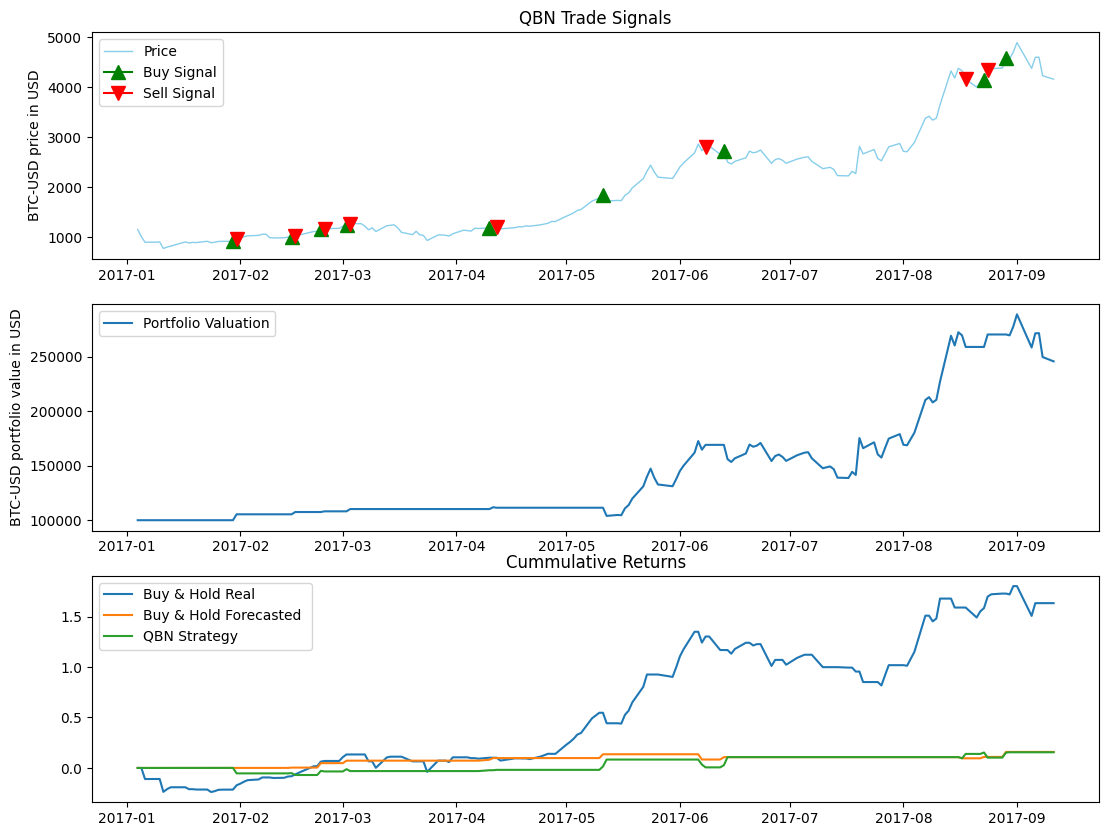

In [86]:
stock_prices = train_quantum_data['prices']
profit = (train_quantum_data['port_value'].iloc[-1]-initial_cash)
print("Total profit {}USD with return of {}%".format(round(profit,2),round(profit*100/initial_cash,2)))

plt.figure(figsize=(13,10))

plt.subplot(3,1,1)
plt.plot(stock_prices, linewidth =1, color = 'skyblue', label = target)
plt.plot(stock_prices.index, BUY_PRICE, marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
plt.plot(stock_prices.index, SELL_PRICE, marker = 'v', markersize = 10, color = 'r', label = 'SELL SIGNAL')
plt.ylabel('{} price in USD'.format(target))
plt.legend(['Price','Buy Signal','Sell Signal'])
plt.title('QBN Trade Signals')


plt.subplot(3,1,2)
plt.plot(train_strategy.index,train_strategy['port_value'])
plt.legend(['Portfolio Valuation'])
plt.ylabel('{} portfolio value in USD'.format(target))

plt.subplot(3,1,3)
plt.title('Cummulative Returns')
plt.plot(train_strategy.index,(1+ train_strategy['returns']*train_strategy['actual']).cumprod()-1)
plt.plot(train_strategy.index,(1+train_strategy['returns']*train_strategy['forecast']).cumprod()-1)
plt.plot(train_strategy.index,(1+train_strategy['returns']*train_strategy['signals']).cumprod()-1)
plt.legend(['Buy & Hold Real','Buy & Hold Forecasted ','QBN Strategy'])


plt.show()

Start date,2017-01-04
End date,2017-09-11
Total months,8
,Backtest
Annual return,23.6%
Cumulative returns,15.5%
Annual volatility,19.9%
Sharpe ratio,1.16
Calmar ratio,3.30
Stability,0.76
Max drawdown,-7.1%


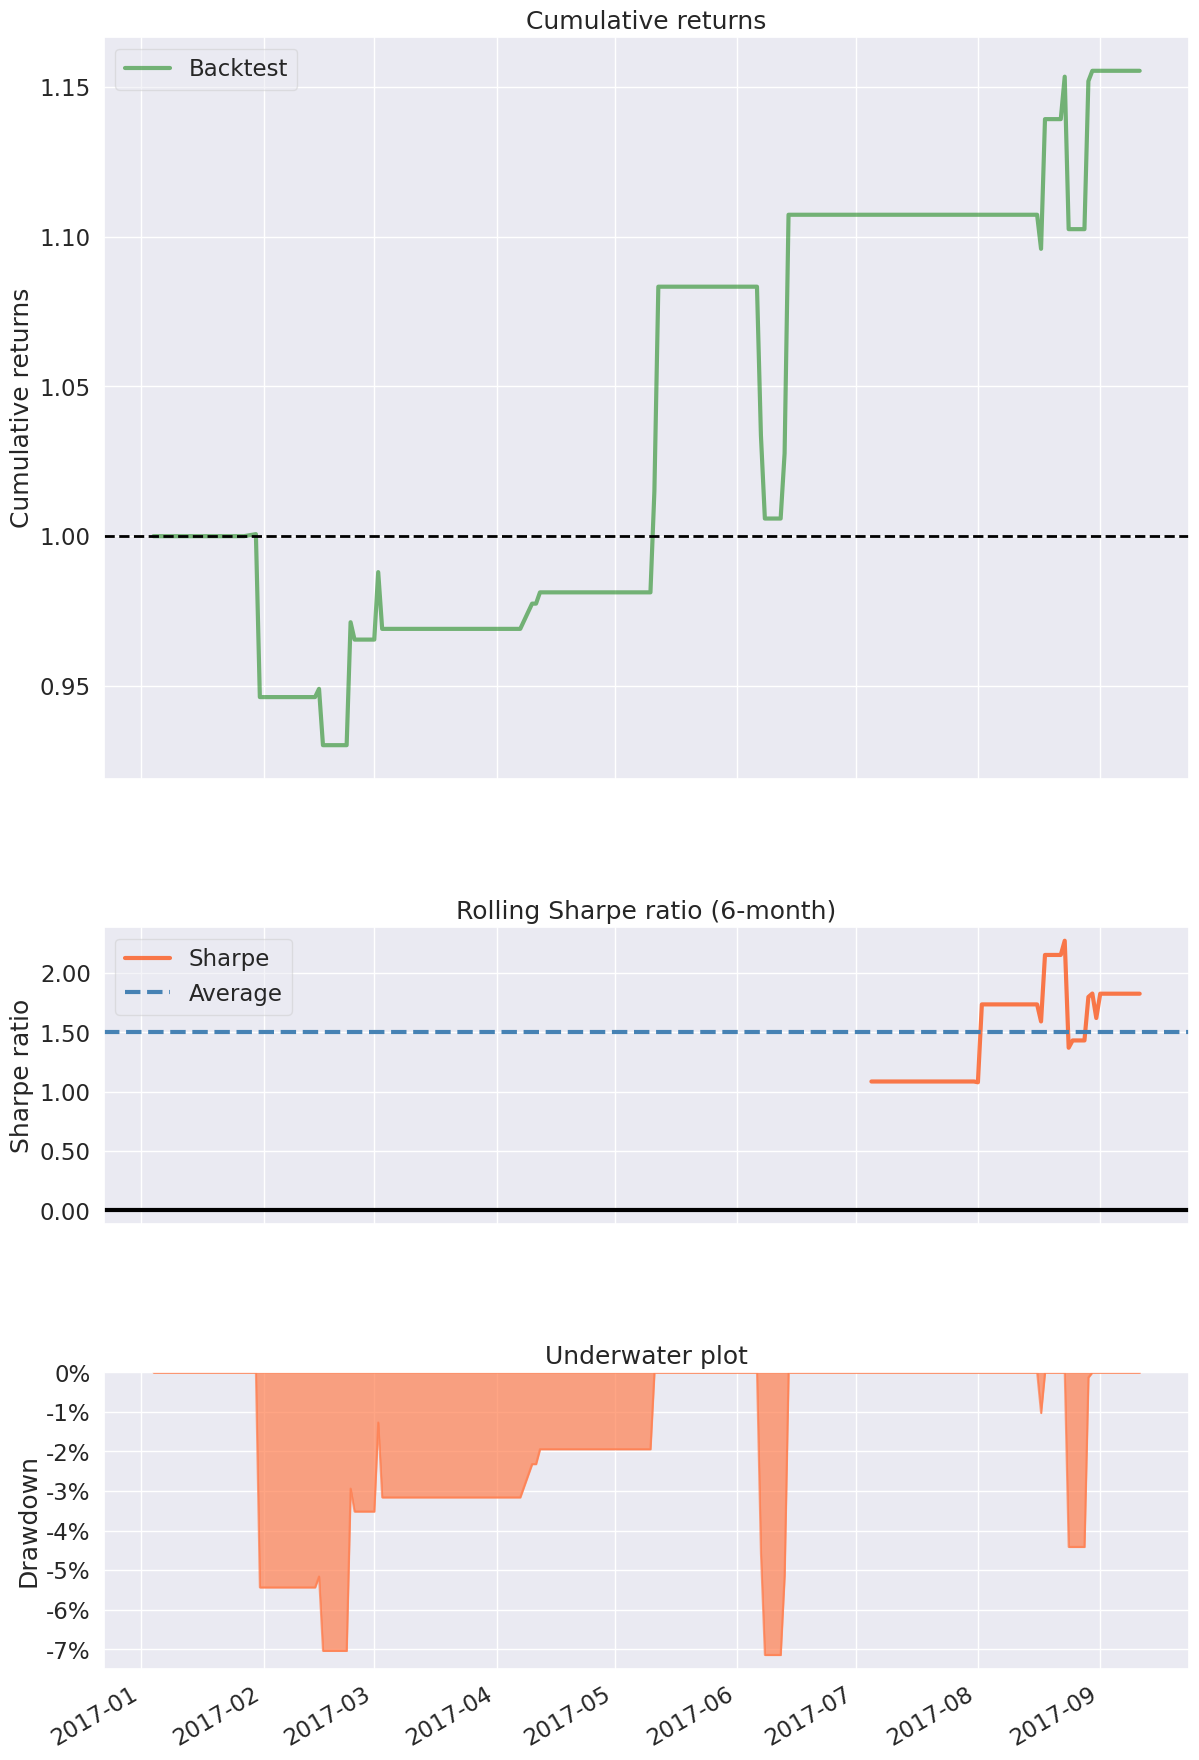

In [87]:
pf.create_simple_tear_sheet(train_strategy['returns']*train_strategy['signals'])

# **Forecasting with Trained QBN on Test Data**

In [88]:
test_data.head()

Ticker,BTC-USD,CNY=X,EUR=X,NVDA,^GSPC,^TNX,^VIX
Date,,,,,,,
2017-09-13,-0.060090,0.000704,-0.001268,0.004481,0.000757,0.011055,-0.007561
2017-09-14,-0.187411,0.001102,0.007065,-0.005694,-0.001101,0.000911,-0.005714
2017-09-15,0.152956,0.001926,-0.002604,0.063223,0.001847,0.002276,-0.025862
2017-09-18,0.117575,-0.000625,-0.001300,0.041308,0.001456,0.012262,-0.001967
2017-09-19,-0.034495,0.003419,-0.001850,-0.001066,0.001110,0.006281,0.002956


#### **Scaling the Test Data:** Adjusting the Reference Level of Percentage Change Data

In [89]:
############ Shifting the mean/referenc e level of the data 
transformed_test_data = test_data.apply(lambda x: (x + (0.5-data.mean())),axis=1)
transformed_test_data.head()

Ticker,BTC-USD,CNY=X,EUR=X,NVDA,^GSPC,^TNX,^VIX
Date,,,,,,,
2017-09-13,0.427568,0.500947,0.499256,0.501561,0.500067,0.511020,0.490614
2017-09-14,0.300246,0.501344,0.507588,0.491387,0.498209,0.500876,0.492461
2017-09-15,0.640614,0.502168,0.497919,0.560303,0.501157,0.502241,0.472313
2017-09-18,0.605232,0.499617,0.499224,0.538388,0.500765,0.512226,0.496209
2017-09-19,0.453162,0.503662,0.498673,0.496014,0.500420,0.506246,0.501131


#### **Converting Test Data to Quantum Data:** Scaling the Percentage Change Data between 0 to $\pi$ for $R_{y}(\theta)$ Gate

In [90]:
####### The Quantum Data: Angle data over bloch sphere ##############
test_quantum_data = 2*np.arctan(np.sqrt((transformed_test_data)/(1-transformed_test_data)))
test_quantum_data['actual'] = test_data[target].apply(lambda x: 1 if x >0 else 0)
test_quantum_data['actual'] = test_quantum_data['actual'].shift(-1)
test_quantum_data.dropna(inplace=True)
test_quantum_data['actual'] = test_quantum_data['actual'].apply(np.int64)
test_quantum_data.head()

Ticker,BTC-USD,CNY=X,EUR=X,NVDA,^GSPC,^TNX,^VIX,actual
Date,,,,,,,,
2017-09-13,1.425420,1.572690,1.569307,1.573919,1.570930,1.592837,1.552023,0
2017-09-14,1.159817,1.573485,1.585973,1.553569,1.567214,1.572548,1.555718,1
2017-09-15,1.855870,1.575133,1.566635,1.691698,1.573110,1.575277,1.515395,1
2017-09-18,1.782846,1.570030,1.569244,1.647648,1.572327,1.595252,1.563214,0
2017-09-19,1.476983,1.578120,1.568142,1.562825,1.571636,1.583288,1.573059,0


#### **QBN Strategy on Quantum Test Data Set:** Forecasting Price Movements & Implementation of QBN Trading Strategy using Qiskit Aer Quantum Simulator

In [91]:
initial_cash = 100000
scenario = {1:'BUY !!!',0:'HOLD !!!',-1:'SELL !!!'}


SIGNALS_TEST = []
STATES_TEST = []
BUY_PRICE_TEST = []
SELL_PRICE_TEST = []
POSITIONS_TEST = []
PORT_VALUE_TEST = []
CASH_TEST = []

log = {'state':np.nan,'buy_price':np.nan,'sell_price':np.nan,'signal':0,
       'position':0,'portfolio value':initial_cash,'cash':initial_cash,
       'last purchase price': 0}

# cr = ClassicalRegister(1)
# model_qc.add_register(cr)

z = 0

for i in range(z,test_quantum_data.shape[0]):
    
    price = data0.loc[test_quantum_data.index[i]][0]
    row = np.append(test_quantum_data.iloc[i,:data.shape[1]].values,0)   
    my_data = encode_data(row) 
    # my_data.append(model_qc,qargs=range(train_quantum_data.iloc[i,:].values.shape[0]),cargs=[0])
    # my_data.append(model_qc,qargs=np.arange(data.shape[1]+1),cargs=[0])
    qbn_circuit = my_data.compose(model_qc,qubits = range(my_data.num_qubits))#,clbits=[0,])
    cr = ClassicalRegister(1)

    qbn_circuit.add_register(cr)
    qbn_circuit.measure(-1,0)

    with Session(service, backend = AerSimulator()) as session:
        sampler = Sampler(session=session)
        result = sampler.run(qbn_circuit,shots=100).result()
        binary_data = result.quasi_dists[0].binary_probabilities()
        state = int(max(zip(binary_data.values(), binary_data.keys()))[1])

    if i == 0:
        log['state'] = state
        if state == 1:
            signal = 1
        else:
            signal = log['signal']

        state = log['state']
        buy_price, sell_price = log['buy_price'],log['sell_price']
        position, port_value, cash = log['position'],log['portfolio value'],log['cash']             
        new_log = log

    elif i == test_quantum_data.shape[0]-1:
        new_log = my_trade(state,price,log)
        state, signal = new_log['state'],new_log['signal']
        buy_price, sell_price = new_log['buy_price'],new_log['sell_price']
        if new_log['position'] > 0:
            cash = new_log['position']*price
            position = 0
            port_value = cash
        else:
            position, port_value, cash = new_log['position'],new_log['portfolio value'],new_log['cash'] 


    else:
        new_log = my_trade(state,price,log)
        state, signal = new_log['state'],new_log['signal']
        buy_price, sell_price = new_log['buy_price'],new_log['sell_price']
        position, port_value, cash = new_log['position'],new_log['portfolio value'],new_log['cash'] 


    log = new_log
    SIGNALS_TEST.append(signal)
    BUY_PRICE_TEST.append(buy_price)
    SELL_PRICE_TEST.append(sell_price)
    STATES_TEST.append(state)
    POSITIONS_TEST.append(position)
    PORT_VALUE_TEST.append(port_value)
    CASH_TEST.append(cash)



    print("\n\n{}: The signal for the next day is {} with expected price movement of {}"
          .format(test_quantum_data.index[i].date(),scenario[signal],state))
    print(log)


base_primitive._run_primitive:INFO:2024-07-29 19:33:54,869: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02027 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 6.85048 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 631.62279 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amp



2017-09-13: The signal for the next day is BUY !!! with expected price movement of 1
{'state': 1, 'buy_price': nan, 'sell_price': nan, 'signal': 0, 'position': 0, 'portfolio value': 100000, 'cash': 100000, 'last purchase price': 0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 365.03768 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-09-14: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 469.25330 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-09-15: The signal for the next day is HOLD !!! with expected price movement of 1
{'state': 1, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 399.89042 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-09-18: The signal for the next day is SELL !!! with expected price movement of 0
{'state': 0, 'signal': -1, 'position': 0, 'cash': 100000, 'buy_price': nan, 'sell_price': nan, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 688.36403 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('u1', 1), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-09-19: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 545.60876 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-09-20: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 1010.43534 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'm



2017-09-21: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 441.36548 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-09-22: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 607.04088 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-09-25: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 461.66182 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-09-26: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 540.77268 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('u1', 1), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-09-27: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 552.35171 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-09-28: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 492.44738 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-09-29: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 358.40654 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-10-02: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 359.58600 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-10-03: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 390.83004 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-10-04: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 445.06335 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-10-05: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 412.51445 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-10-06: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 471.27199 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-10-09: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 918.98751 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-10-10: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 508.70347 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-10-11: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 352.78749 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-10-12: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 384.21154 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-10-13: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 372.00665 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-10-16: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 408.54788 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-10-17: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 369.60149 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-10-18: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 971.29297 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-10-19: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 434.15236 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-10-20: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 100000, 'last purchase price': 0, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 401.94488 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-10-23: The signal for the next day is BUY !!! with expected price movement of 1
{'state': 1, 'signal': 1, 'position': 16.86249695869882, 'cash': 0, 'buy_price': 5930.31982421875, 'sell_price': nan, 'last purchase price': 5930.31982421875, 'portfolio value': 100000.0}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 386.39331 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-10-24: The signal for the next day is SELL !!! with expected price movement of 0
{'state': 0, 'signal': -1, 'position': 16.86249695869882, 'cash': 0, 'buy_price': nan, 'sell_price': nan, 'last purchase price': 5930.31982421875, 'portfolio value': 93192.95249724275}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 418.84589 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-10-25: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 16.86249695869882, 'cash': 0, 'last purchase price': 5930.31982421875, 'portfolio value': 96972.84421662874}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 360.26096 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('u1', 1), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-10-26: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 16.86249695869882, 'cash': 0, 'last purchase price': 5930.31982421875, 'portfolio value': 99570.17923401613}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 570.94097 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-10-27: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 16.86249695869882, 'cash': 0, 'last purchase price': 5930.31982421875, 'portfolio value': 97480.4070218138}


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01645 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 3.51644 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.02050 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 430.37057 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'dela



2017-10-30: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 16.86249695869882, 'cash': 0, 'last purchase price': 5930.31982421875, 'portfolio value': 103376.03985740979}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 360.35156 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('u1', 1), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-10-31: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 16.86249695869882, 'cash': 0, 'last purchase price': 5930.31982421875, 'portfolio value': 109073.37368091923}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 379.57025 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-11-01: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 16.86249695869882, 'cash': 0, 'last purchase price': 5930.31982421875, 'portfolio value': 114113.74528160904}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 363.77716 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-11-02: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 16.86249695869882, 'cash': 0, 'last purchase price': 5930.31982421875, 'portfolio value': 119361.1847221496}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 378.78704 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-11-03: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 16.86249695869882, 'cash': 0, 'last purchase price': 5930.31982421875, 'portfolio value': 121540.82712688328}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 379.14634 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-11-06: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 16.86249695869882, 'cash': 0, 'last purchase price': 5930.31982421875, 'portfolio value': 118421.265189524}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 1178.50828 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'm



2017-11-07: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 16.86249695869882, 'cash': 0, 'last purchase price': 5930.31982421875, 'portfolio value': 120472.08404571482}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 371.01936 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-11-08: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 16.86249695869882, 'cash': 0, 'last purchase price': 5930.31982421875, 'portfolio value': 125788.99894979908}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 358.27327 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-11-09: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 16.86249695869882, 'cash': 0, 'last purchase price': 5930.31982421875, 'portfolio value': 120458.5973416043}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 435.24837 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-11-10: The signal for the next day is BUY !!! with expected price movement of 1
{'state': 1, 'signal': 1, 'position': 16.86249695869882, 'cash': 0, 'buy_price': nan, 'sell_price': nan, 'last purchase price': 0, 'portfolio value': 111598.36792766252}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 380.09477 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-11-13: The signal for the next day is SELL !!! with expected price movement of 0
{'state': 0, 'signal': -1, 'cash': 110609.38412776304, 'position': 0, 'buy_price': nan, 'sell_price': 6559.490234375, 'last purchase price': 0, 'portfolio value': 110609.38412776304}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 447.48998 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-11-14: The signal for the next day is BUY !!! with expected price movement of 1
{'state': 1, 'signal': 1, 'position': 16.6687087560205, 'cash': 0, 'buy_price': 6635.75, 'sell_price': nan, 'last purchase price': 6635.75, 'portfolio value': 110609.38412776303}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 381.11973 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-11-15: The signal for the next day is SELL !!! with expected price movement of 0
{'state': 0, 'signal': -1, 'cash': 121940.60630413964, 'position': 0, 'buy_price': nan, 'sell_price': 7315.5400390625, 'last purchase price': 0, 'portfolio value': 121940.60630413964}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 981.88210 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-11-17: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 121940.60630413964, 'last purchase price': 0, 'portfolio value': 121940.60630413964}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 363.86299 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-11-20: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 121940.60630413964, 'last purchase price': 0, 'portfolio value': 121940.60630413964}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 365.74507 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-11-21: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 121940.60630413964, 'last purchase price': 0, 'portfolio value': 121940.60630413964}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 418.90597 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-11-22: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 121940.60630413964, 'last purchase price': 0, 'portfolio value': 121940.60630413964}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 374.38345 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('u1', 1), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-11-24: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 121940.60630413964, 'last purchase price': 0, 'portfolio value': 121940.60630413964}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 395.27512 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-11-27: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 121940.60630413964, 'last purchase price': 0, 'portfolio value': 121940.60630413964}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 374.56584 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-11-28: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 121940.60630413964, 'last purchase price': 0, 'portfolio value': 121940.60630413964}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 378.96895 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-11-29: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 121940.60630413964, 'last purchase price': 0, 'portfolio value': 121940.60630413964}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 374.58587 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-11-30: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 121940.60630413964, 'last purchase price': 0, 'portfolio value': 121940.60630413964}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 391.17169 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-12-01: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 121940.60630413964, 'last purchase price': 0, 'portfolio value': 121940.60630413964}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 533.22053 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-12-04: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 121940.60630413964, 'last purchase price': 0, 'portfolio value': 121940.60630413964}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 353.81389 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-12-05: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 121940.60630413964, 'last purchase price': 0, 'portfolio value': 121940.60630413964}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 352.74458 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-12-06: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 121940.60630413964, 'last purchase price': 0, 'portfolio value': 121940.60630413964}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 972.83530 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-12-07: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 121940.60630413964, 'last purchase price': 0, 'portfolio value': 121940.60630413964}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 357.94640 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('u1', 1), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-12-08: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 121940.60630413964, 'last purchase price': 0, 'portfolio value': 121940.60630413964}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 376.55425 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-12-11: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 121940.60630413964, 'last purchase price': 0, 'portfolio value': 121940.60630413964}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 376.16277 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('u1', 1), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-12-12: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 121940.60630413964, 'last purchase price': 0, 'portfolio value': 121940.60630413964}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 494.54641 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-12-13: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 121940.60630413964, 'last purchase price': 0, 'portfolio value': 121940.60630413964}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 562.01100 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-12-14: The signal for the next day is BUY !!! with expected price movement of 1
{'state': 1, 'signal': 1, 'position': 7.361784973686286, 'cash': 0, 'buy_price': 16564.0, 'sell_price': nan, 'last purchase price': 16564.0, 'portfolio value': 121940.60630413964}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 385.89478 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-12-15: The signal for the next day is SELL !!! with expected price movement of 0
{'state': 0, 'signal': -1, 'cash': 130354.39322626295, 'position': 0, 'buy_price': nan, 'sell_price': 17706.900390625, 'last purchase price': 0, 'portfolio value': 130354.39322626295}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 1009.28712 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'm



2017-12-18: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 130354.39322626295, 'last purchase price': 0, 'portfolio value': 130354.39322626295}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 511.53731 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('u1', 1), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-12-19: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 130354.39322626295, 'last purchase price': 0, 'portfolio value': 130354.39322626295}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 364.02345 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-12-20: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 130354.39322626295, 'last purchase price': 0, 'portfolio value': 130354.39322626295}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 375.46062 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-12-21: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 130354.39322626295, 'last purchase price': 0, 'portfolio value': 130354.39322626295}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 526.84736 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-12-22: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 130354.39322626295, 'last purchase price': 0, 'portfolio value': 130354.39322626295}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 374.31073 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('u1', 1), ('measure', 1), ('cx', 2), ('barrier', 8), ('ry', 1), ('u2', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-12-26: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 130354.39322626295, 'last purchase price': 0, 'portfolio value': 130354.39322626295}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 383.79407 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'mc



2017-12-27: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 130354.39322626295, 'last purchase price': 0, 'portfolio value': 130354.39322626295}


INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 1037.63938 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('x', 1), ('unitary', 1), ('rccx', 3), ('ccx', 3), ('measure', 1), ('cx', 2), ('barrier', 8), ('u2', 1), ('ry', 1), ('u1', 1)} to target basis {'save_amplitudes_sq', 'save_probabilities_dict', 't', 'qerror_loc', 'cx', 'set_density_matrix', 'continue_loop', 'sx', 'set_stabilizer', 'csx', 'unitary', 'rzz', 'ccx', 'u', 'diagonal', 'save_statevector', 'rx', 'cu', 'save_stabilizer', 'store', 'mcrz', 'ecr', 'reset', 'sdg', 'save_density_matrix', 'save_unitary', 'multiplexer', 'barrier', 'save_state', 'r', 'rzx', 'ryy', 'kraus', 'mcp', 'cz', 'set_unitary', 'y', 'save_superop', 'initialize', 'mcu2', 'delay', 'save_matrix_product_state', 'mcz', 'h', 'sxdg', 'mcu', 'x', 's', 'save_clifford', 'measure', 'save_probabilities', 'save_expval_var', 'u2', 'pauli', 'mcx_gray', 'quantum_channel', 'set_superop', 'mcry', 'mcu1', 'rz', 'm



2017-12-28: The signal for the next day is HOLD !!! with expected price movement of 0
{'state': 0, 'signal': 0, 'buy_price': nan, 'sell_price': nan, 'position': 0, 'cash': 130354.39322626295, 'last purchase price': 0, 'portfolio value': 130354.39322626295}


#### **QBN Strategy Results on Test Data**

In [92]:
test_quantum_data['prices'] = data0.loc[test_quantum_data.index].iloc[z:,0]
test_quantum_data['returns'] = data.loc[test_quantum_data.index].iloc[z:,0]
test_quantum_data['forecast'] = STATES_TEST
test_quantum_data['signals'] = SIGNALS_TEST
test_quantum_data['positions'] = POSITIONS_TEST
test_quantum_data['cash'] = CASH_TEST
test_quantum_data['port_value'] = PORT_VALUE_TEST



reference = test_quantum_data['actual']
score = accuracy_score(test_quantum_data['actual'],np.array(STATES_TEST))*100
print('\n\nQBN prediction accuracy score is:',round(accuracy_score(test_quantum_data['actual'],test_quantum_data['forecast'])*100,2),'%')
print("The confusion matrix is:\n",confusion_matrix(test_quantum_data['actual'],test_quantum_data['forecast']))

test_strategy = test_quantum_data.iloc[:,7:]
test_strategy.tail()



QBN prediction accuracy score is: 40.54 %
The confusion matrix is:
 [[26  3]
 [41  4]]


Ticker,actual,prices,returns,forecast,signals,positions,cash,port_value
Date,,,,,,,,
2017-12-21,0,15802.900391,-0.049427,0,0,0.0,130354.393226,130354.393226
2017-12-22,1,13831.799805,-0.124730,0,0,0.0,130354.393226,130354.393226
2017-12-26,0,16099.799805,0.163970,0,0,0.0,130354.393226,130354.393226
2017-12-27,0,15838.500000,-0.016230,0,0,0.0,130354.393226,130354.393226
2017-12-28,1,14606.500000,-0.077785,0,0,0.0,130354.393226,130354.393226


#### **QBN Strategy Plots for Out of Sample Data**

Total profit 30354.39USD with return of 30.35%


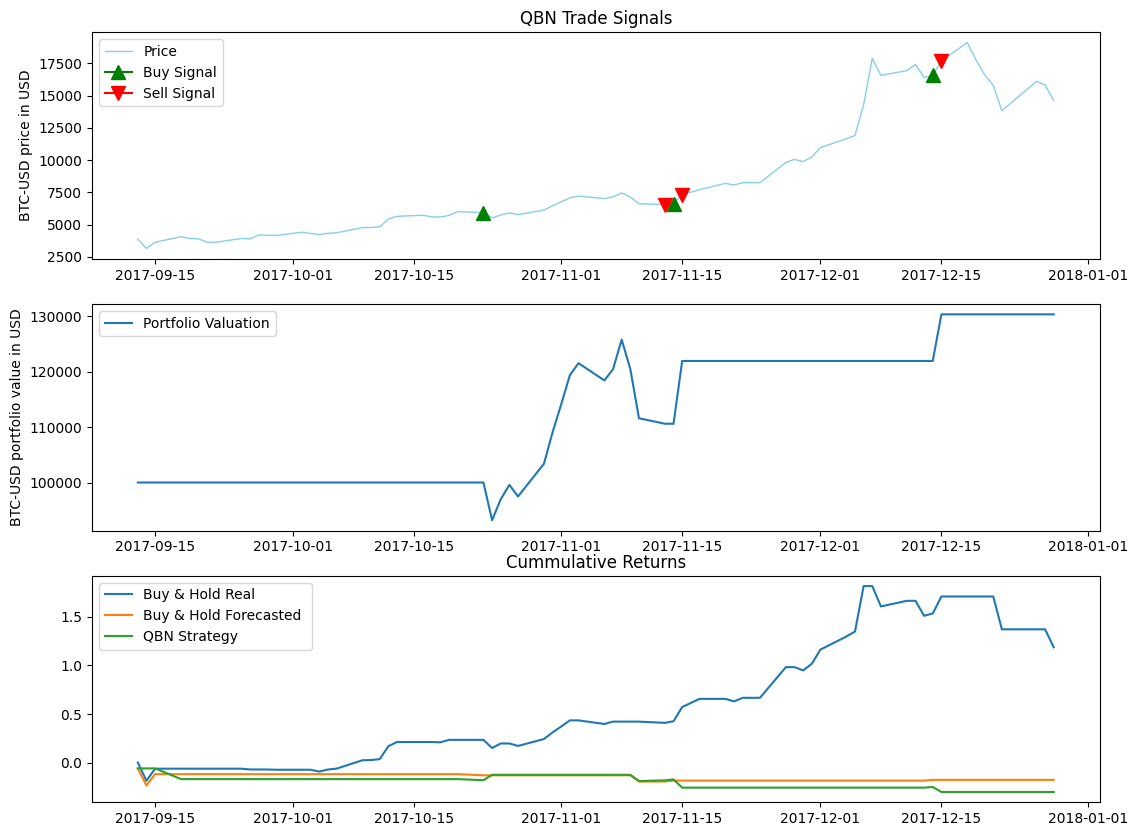

In [93]:
stock_prices = test_quantum_data['prices']
profit = (test_quantum_data['port_value'].iloc[-1]-initial_cash)
print("Total profit {}USD with return of {}%".format(round(profit,2),round(profit*100/initial_cash,2)))

plt.figure(figsize=(13,10))

plt.subplot(3,1,1)
plt.plot(stock_prices, linewidth =1, color = 'skyblue', label = target)
plt.plot(stock_prices.index, BUY_PRICE_TEST, marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
plt.plot(stock_prices.index, SELL_PRICE_TEST, marker = 'v', markersize = 10, color = 'r', label = 'SELL SIGNAL')
plt.ylabel('{} price in USD'.format(target))
plt.legend(['Price','Buy Signal','Sell Signal'])
plt.title('QBN Trade Signals')


plt.subplot(3,1,2)
plt.plot(test_strategy.index,test_strategy['port_value'])
plt.legend(['Portfolio Valuation'])
plt.ylabel('{} portfolio value in USD'.format(target))

plt.subplot(3,1,3)
plt.title('Cummulative Returns')
plt.plot(test_strategy.index,(1+test_strategy['returns']*test_strategy['actual']).cumprod()-1)
plt.plot(test_strategy.index,(1+test_strategy['returns']*test_strategy['forecast']).cumprod()-1)
plt.plot(test_strategy.index,(1+test_strategy['returns']*test_strategy['signals']).cumprod()-1)
plt.legend(['Buy & Hold Real','Buy & Hold Forecasted ','QBN Strategy'])


plt.show()

Start date,2017-09-13
End date,2017-12-28
Total months,3
,Backtest
Annual return,-70.7%
Cumulative returns,-30.3%
Annual volatility,37.9%
Sharpe ratio,-3.04
Calmar ratio,-2.34
Stability,0.66
Max drawdown,-30.3%


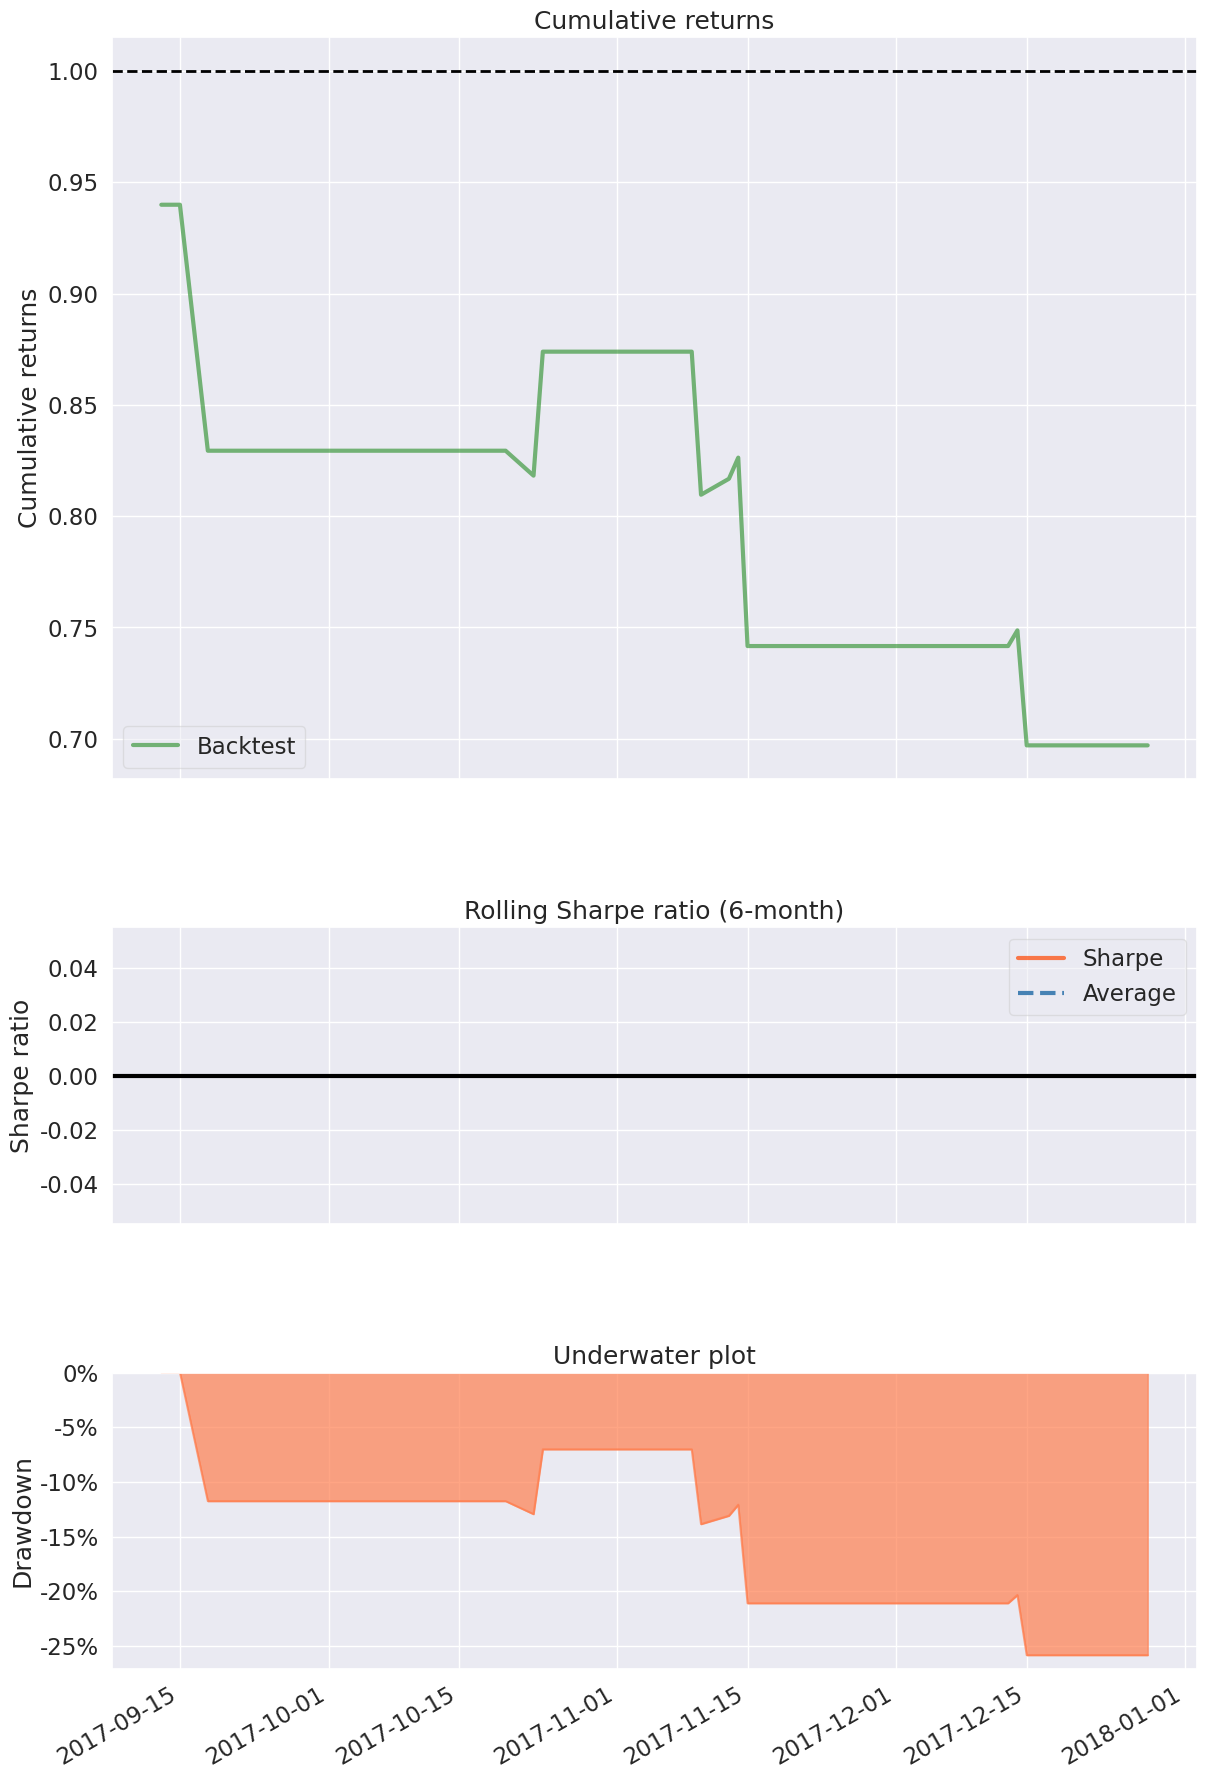

In [94]:
pf.create_simple_tear_sheet(test_strategy['returns']*test_strategy['signals'])

# **On Real Hardware**
#### **QBN Execution on Real IBM Quantum Computer:** Exploring the Probable Events 

In [106]:
#TO GET THE LEAST BUSY QPU
my_backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)
print(my_backend)

<IBMBackend('ibm_osaka')>


In [104]:
pm = generate_preset_pass_manager(backend=my_backend, optimization_level=1)
isa_circuit = pm.run(qbn_qc)

# with Session(service, backend = my_backend) as session:
sampler = SamplerV2(mode=my_backend)
job = sampler.run([isa_circuit])
result = job.result()
pub_result = result[0]

counts = pub_result.data.meas.get_counts()
num_shots = np.array(list(binary_data.values())).sum() #this gives the number of shots used
prob_dist = {}
for key in counts:
    prob_dist[key] = counts[key]/num_shots

print(prob_dist)

{'11000101': 5.0, '00101110': 24.0, '11111110': 36.0, '01101010': 34.0, '01010101': 10.0, '01101000': 15.0, '00010111': 2.0, '11001100': 23.0, '11011010': 14.0, '11010001': 15.0, '10100001': 10.0, '10110011': 18.0, '11101010': 24.0, '00110001': 14.0, '00110101': 11.0, '11011100': 13.0, '10000001': 10.0, '11010000': 11.0, '00110110': 27.0, '01110010': 27.0, '10010110': 12.0, '00001001': 12.0, '11000100': 16.0, '11111011': 17.0, '01000001': 4.0, '10100100': 22.0, '00101000': 17.0, '01111111': 14.0, '01011000': 24.0, '01001100': 14.0, '01110011': 8.0, '01110111': 20.0, '11110101': 16.0, '10111101': 10.0, '00101010': 35.0, '00101101': 15.0, '01100100': 24.0, '01101011': 16.0, '10110000': 24.0, '01010010': 17.0, '10000000': 18.0, '11000110': 19.0, '01001111': 7.0, '10111110': 28.0, '00100110': 24.0, '11110010': 25.0, '11100101': 15.0, '11010010': 17.0, '00100100': 32.0, '01011110': 18.0, '11010110': 17.0, '11101011': 18.0, '11011000': 13.0, '01010001': 11.0, '10011101': 11.0, '11110001': 25



 State with max probability is: 11110000


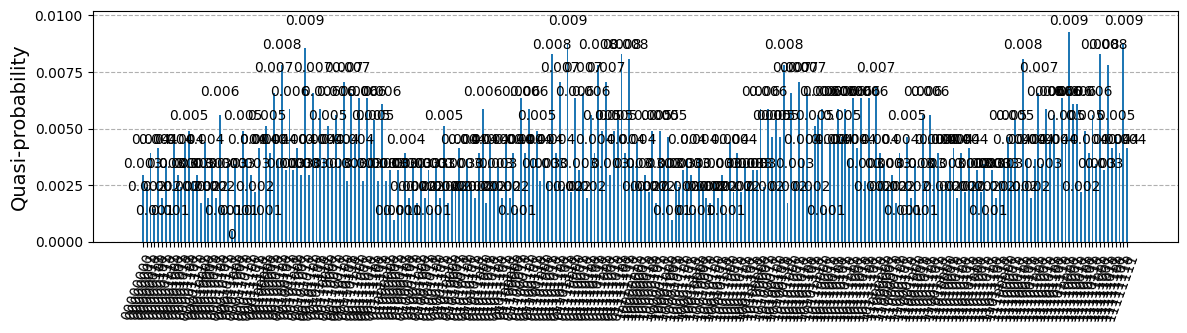

In [105]:
######## Plotting the distribution #############

m = 500 # take m largest probability values
top_keys = heapq.nlargest(m, prob_dist, key=prob_dist.get)
top_states = {key: prob_dist[key] for key in top_keys}
print(f"\n\n State with max probability is: {list(top_states.keys())[0]}")

plot_histogram(top_states,figsize=(14,3))